In [361]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, date
from scipy import stats
from sklearn.feature_selection import chi2
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from statistics import*

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [362]:
df=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [363]:
print(" Shape of training dataframe: ", df.shape)
print(" Shape of testing dataframe: ", test.shape)
# Drop duplicates
df.drop_duplicates()
test.drop_duplicates()
print(df.shape)
print(test.shape)

 Shape of training dataframe:  (233154, 41)
 Shape of testing dataframe:  (112392, 40)
(233154, 41)
(112392, 40)


In [364]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             233154 non-null  int64  
 1   DISBURSED_AMOUNT                     233154 non-null  int64  
 2   ASSET_COST                           233154 non-null  int64  
 3   LTV                                  233154 non-null  float64
 4   BRANCH_ID                            233154 non-null  int64  
 5   SUPPLIER_ID                          233154 non-null  int64  
 6   MANUFACTURER_ID                      233154 non-null  int64  
 7   CURRENT_PINCODE_ID                   233154 non-null  int64  
 8   DATE_OF_BIRTH                        233154 non-null  object 
 9   EMPLOYMENT_TYPE                      225493 non-null  object 
 10  DISBURSAL_DATE                       233154 non-null  object 
 11  STATE_ID     

In [366]:
null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Number', 'Percent'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " Attributes"})
 
print ("Null Values in each column:\n", missing_data.sort_values(by ='Number', ascending = False))

Null Values in each column:
                              Attributes  Number   Percent
0                       EMPLOYMENT_TYPE    7661  0.032858
21        PERFORM_CNS_SCORE_DESCRIPTION       0  0.000000
23                       DISBURSAL_DATE       0  0.000000
24                           ASSET_COST       0  0.000000
25                                  LTV       0  0.000000
26                            BRANCH_ID       0  0.000000
27                          SUPPLIER_ID       0  0.000000
28                      MANUFACTURER_ID       0  0.000000
29                   CURRENT_PINCODE_ID       0  0.000000
30                        DATE_OF_BIRTH       0  0.000000
31                             STATE_ID       0  0.000000
32                    PERFORM_CNS_SCORE       0  0.000000
33                     EMPLOYEE_CODE_ID       0  0.000000
34                    MOBILENO_AVL_FLAG       0  0.000000
35                          AADHAR_FLAG       0  0.000000
36                             PAN_FLAG    

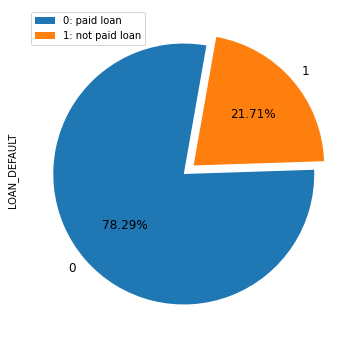

In [367]:
df['LOAN_DEFAULT'].value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', explode= (0.05, 0.05), startangle=80, legend=True, fontsize=12, figsize=(14,6), textprops={'color':"black"})
plt.legend(["0: paid loan","1: not paid loan"]);

In [368]:
### The dataset have several features which are of no use in EDA and 
#visualizations of the dataset. What we need to do is the seperate those
#columns with datatypes int64 and float 64
#Further we know that numerical dataset is of two types :
#* Continous
#* Discrete
#There is no rule of classifying the datasets into these categories but for our
#use we can assume that columns which have less than 30 unique values is 
#considered discrete and the rest are continous

In [369]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID',
       'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG',
       'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
       'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
       'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS',
       'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT'],
      dtype='object')

In [370]:
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<30]
discrete_features

['MANUFACTURER_ID',
 'STATE_ID',
 'MOBILENO_AVL_FLAG',
 'AADHAR_FLAG',
 'PAN_FLAG',
 'VOTERID_FLAG',
 'DRIVING_FLAG',
 'PASSPORT_FLAG',
 'PRI_OVERDUE_ACCTS',
 'SEC_ACTIVE_ACCTS',
 'SEC_OVERDUE_ACCTS',
 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
 'NO_OF_INQUIRIES',
 'LOAN_DEFAULT']

In [371]:
df.isna().sum()

UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

In [372]:
df = df[df['EMPLOYMENT_TYPE'].notna()]

In [373]:
g1=df.groupby('LOAN_DEFAULT')

In [374]:
loan_default_group=g1.describe()
loan_default_group.to_excel('loanDefaultGroupBy.xlsx')
g1.describe()

UNIQUEID                                                    \
                 count           mean           std       min        25%   
LOAN_DEFAULT                                                               
0             176526.0  534465.757260  67576.438092  417428.0  476205.25   
1              48967.0  540045.618886  70841.112798  417439.0  477396.00   

                                            DISBURSED_AMOUNT                \
                   50%        75%       max            count          mean   
LOAN_DEFAULT                                                                 
0             533590.5  592331.75  671084.0         176526.0  53707.242282   
1             544061.0  603702.00  658671.0          48967.0  56163.947454   

              ... DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS       NO_OF_INQUIRIES  \
              ...                                 75%   max           count   
LOAN_DEFAULT  ...                                                             
0             ...                                 0.0  20.0        176526.0   
1             ...                                 0.0  12.0         48967.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
LOAN_DEFAULT                                                
0             0.192448  0.668739  0.0  0.0  0.0  0.0  36.0  
1             0.267956  0.839814  0.0  0.0  0.0  0.0  19.0  

[2 rows x 272 columns]

In [375]:
 boxplot_columns=['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 
        'DISBURSAL_DATE', 
       'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS',
       'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_and_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_and_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES']

In [376]:
def plot_box(feature, color, data):
    plt.figure(figsize=(10,6))
    plt.title("Box Plot of %s" % feature)
    try:
        sns.boxplot(data[feature].dropna(),color=color)
        plt.show()
    except:
        pass

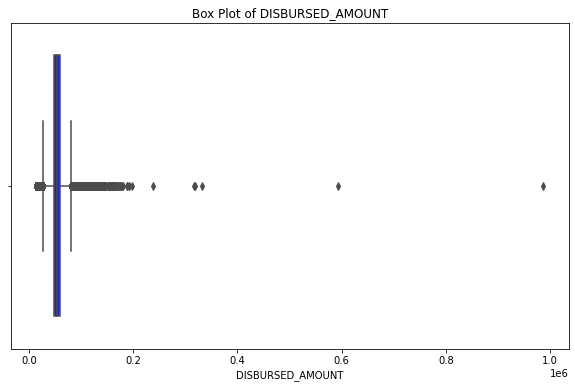

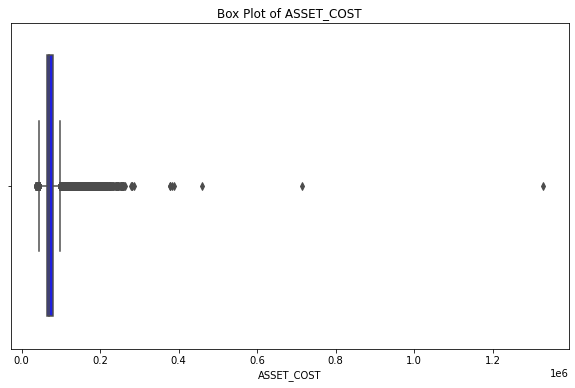

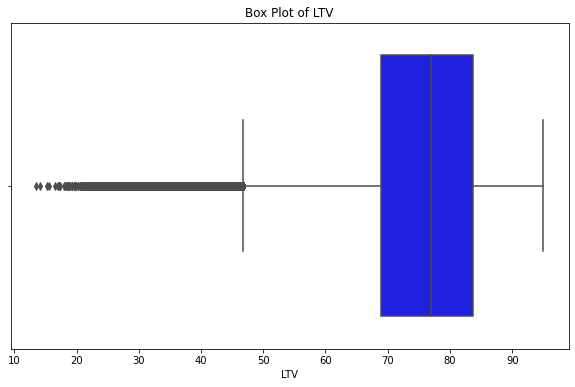

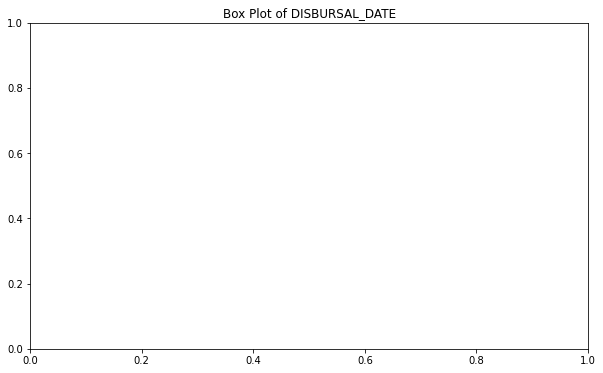

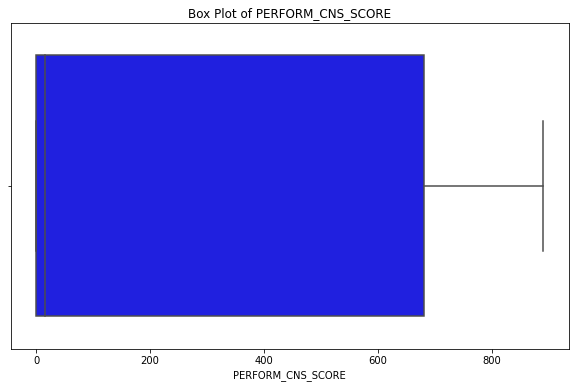

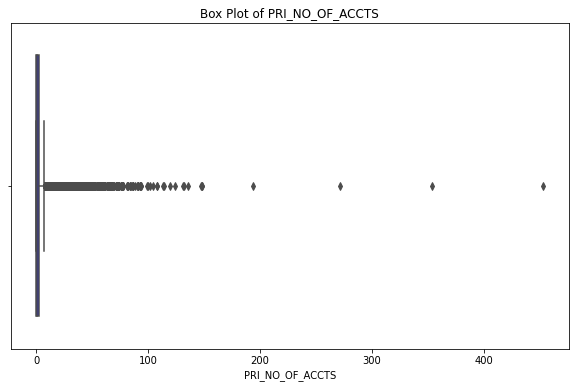

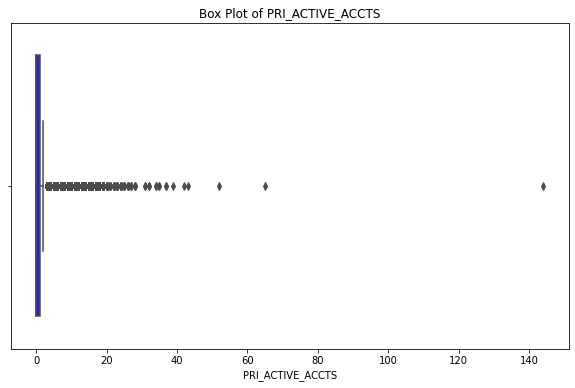

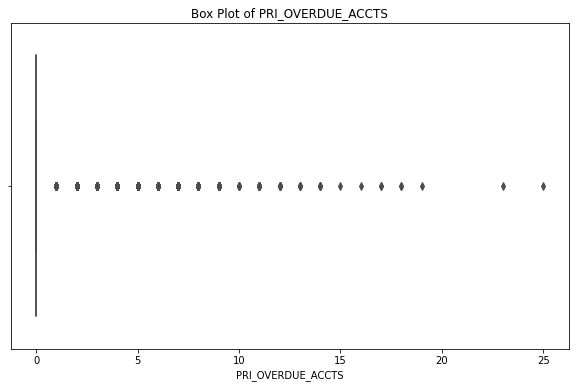

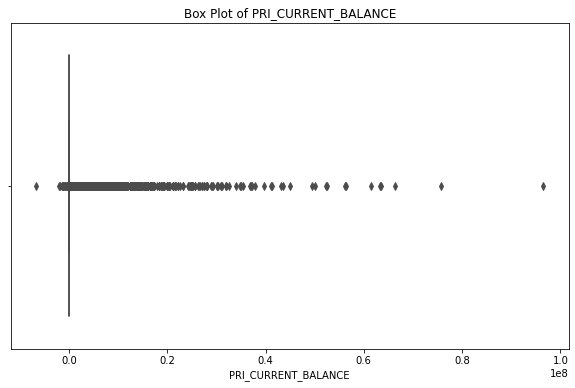

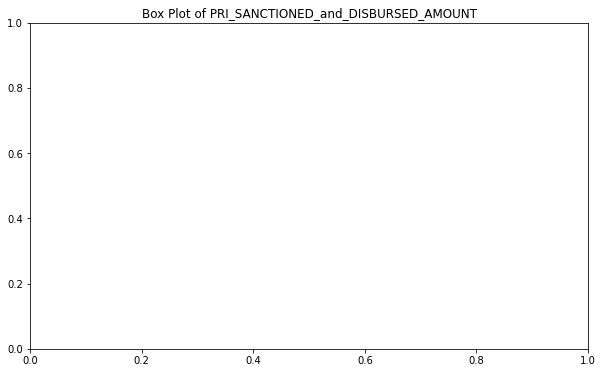

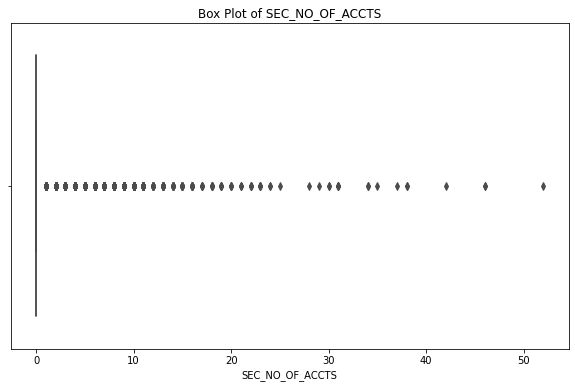

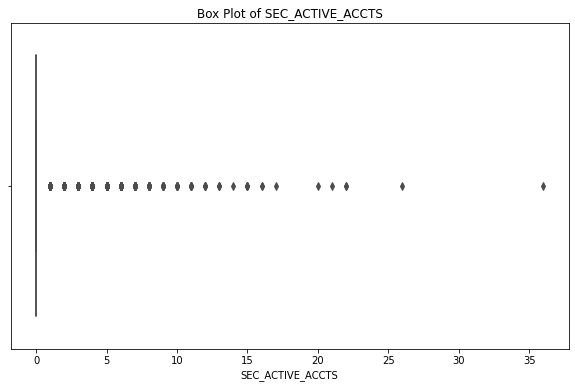

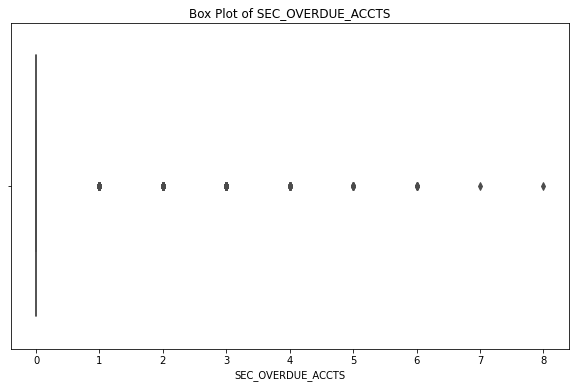

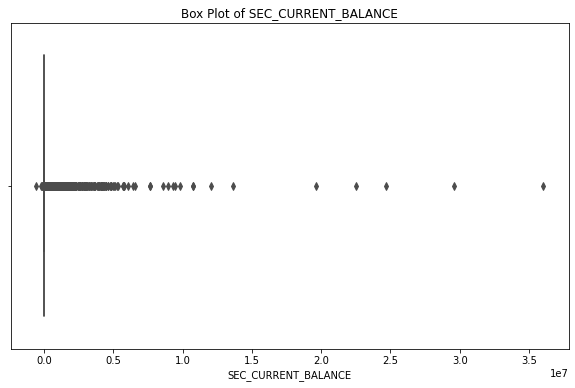

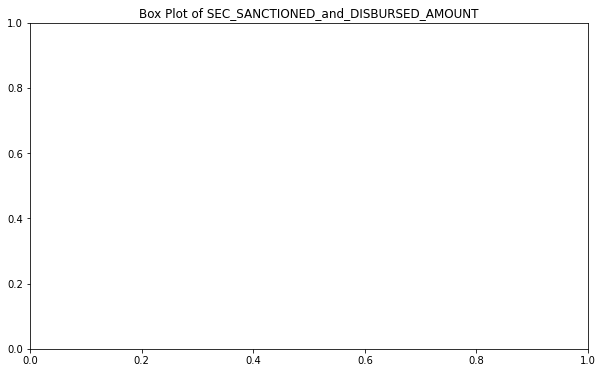

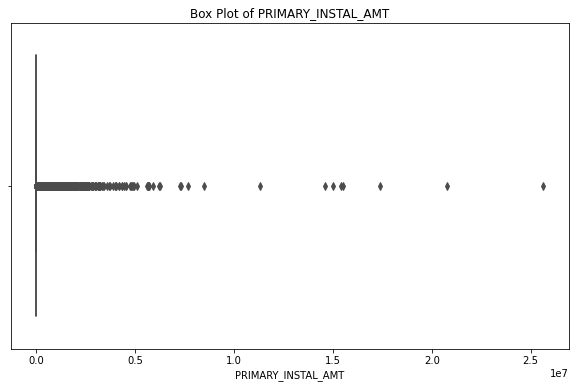

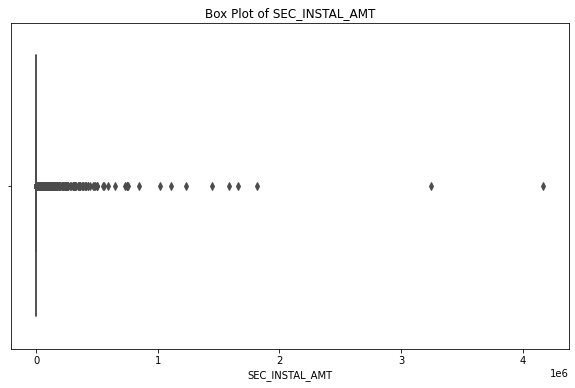

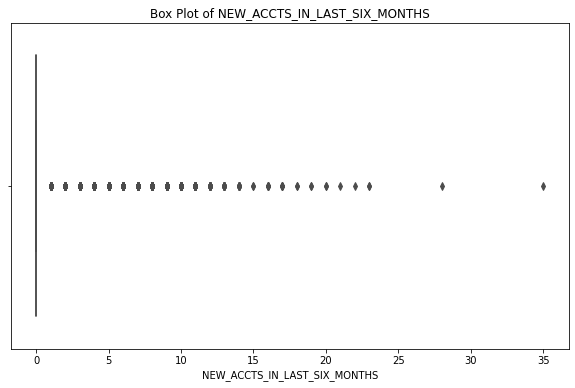

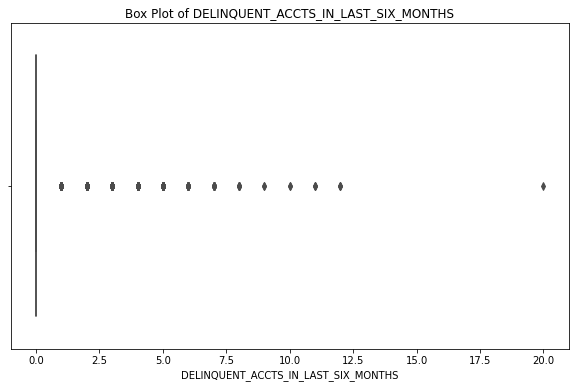

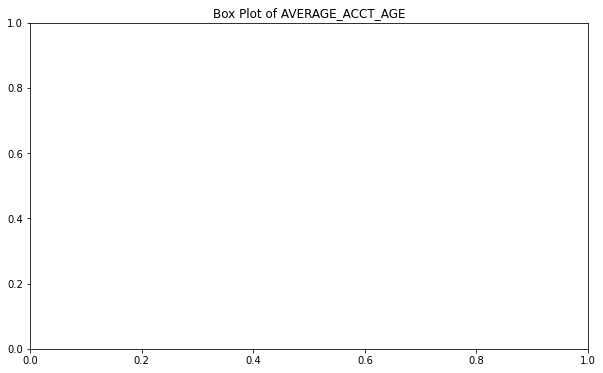

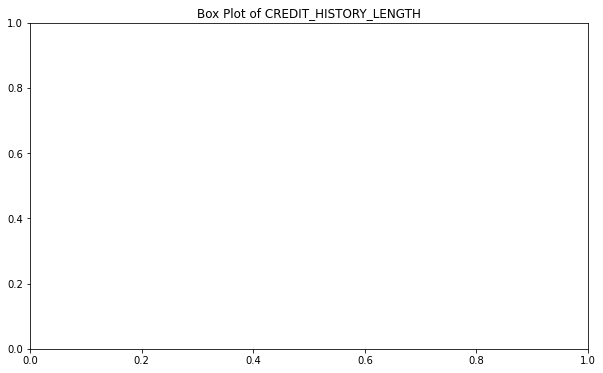

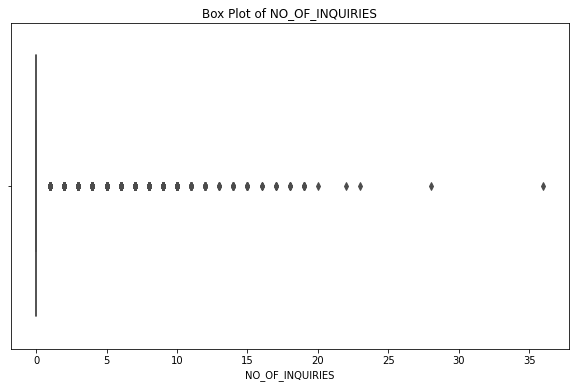

In [377]:
for column in boxplot_columns:
  plot_box(column,'blue',df)

In [378]:
#changing outlier values to mean of column
def removeOutlier(x):
    if x <= lower:
        return(data_mean)
    elif x>= (upper):
        return(data_mean)
    else:
        return(x)

In [379]:
df_with_outlier=df.copy()

In [380]:
#Outlier Removal for Important Attributes
cols=["DISBURSED_AMOUNT","LTV","PERFORM_CNS_SCORE","PRI_NO_OF_ACCTS","PRI_OVERDUE_ACCTS","PRI_CURRENT_BALANCE","PRI_SANCTIONED_AMOUNT","PRI_DISBURSED_AMOUNT"]
for column in cols:
  print(column)
  obs = len(df[column])
  print("No. of observations in column: ",obs)
  data_mean, data_std = mean(df[column]), std(df[column])
  print('Statistics: Mean=%.3f, Std dev=%.3f' % (data_mean, data_std))
  cut_off = data_std * 3
  lower, upper = data_mean - cut_off, data_mean + cut_off
  outliers = [x for x in df[column] if x < lower or x > upper]
  print('Identified outliers: %d' % len(outliers))
  print()
  df[column]= df[column].apply(removeOutlier)

DISBURSED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=54240.729, Std dev=12775.562
Identified outliers: 3036

LTV
No. of observations in column:  225493
Statistics: Mean=74.807, Std dev=11.442
Identified outliers: 2645

PERFORM_CNS_SCORE
No. of observations in column:  225493
Statistics: Mean=293.040, Std dev=338.874
Identified outliers: 0

PRI_NO_OF_ACCTS
No. of observations in column:  225493
Statistics: Mean=2.462, Std dev=5.223
Identified outliers: 3991

PRI_OVERDUE_ACCTS
No. of observations in column:  225493
Statistics: Mean=0.159, Std dev=0.553
Identified outliers: 6194

PRI_CURRENT_BALANCE
No. of observations in column:  225493
Statistics: Mean=168481.316, Std dev=951667.062
Identified outliers: 2152

PRI_SANCTIONED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=222073.639, Std dev=2411716.168
Identified outliers: 592

PRI_DISBURSED_AMOUNT
No. of observations in column:  225493
Statistics: Mean=221609.814, Std dev=2414692.085
Identified outlie

In [381]:
#drop useless features
train = df.drop([ 'DATE_OF_BIRTH' , 'STATE_ID', 'EMPLOYEE_CODE_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','BRANCH_ID'],axis=1)

In [382]:
#convert DISBURSAL_DATE to months
def DateToAge(df,label):
  dob=df[label].to_list()
  ageList=[]
  try:
    for i in range(len(dob)):
      dob[i]=dob[i].replace('-','/')
      born = datetime.strptime(dob[i], "%d/%m/%Y").date()
      today = date.today()
      if(label!='DISBURSAL_DATE'):
        age=today.year - born.year - ((today.month,today.day) < (born.month,born.day))
      else:
        age=(today.year - born.year) * 12 + today.month - born.month
      ageList.append(age)
    df[label]=ageList
  except:
    pass
  return df
train=DateToAge(train,'DISBURSAL_DATE')


In [383]:
# converts AVERAGE_ACCT_AGE and CREDIT_HISTORY_LENGTH column to number of months till date
def TimeToMonths(df,label):
  col=df[label].to_list()
  monthList=[]
  for i in range(len(col)):
    a=col[i].split(" ")
    b=a[0].split("yrs")
    c=a[1].split("mon")
    months=int(b[0])*12+int(c[0])
    monthList.append(months)
  df[label]=monthList
  return df
train=TimeToMonths(train,'AVERAGE_ACCT_AGE')
train=TimeToMonths(train,'CREDIT_HISTORY_LENGTH')

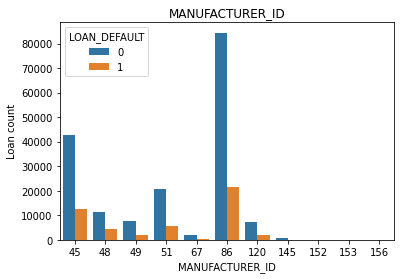

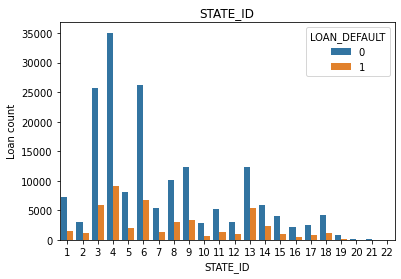

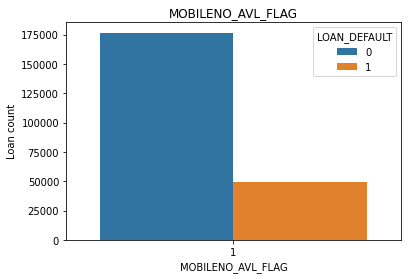

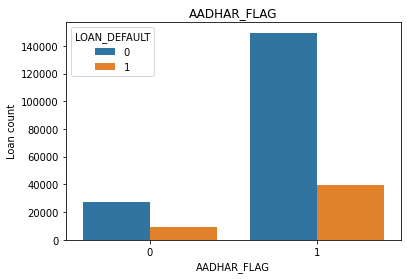

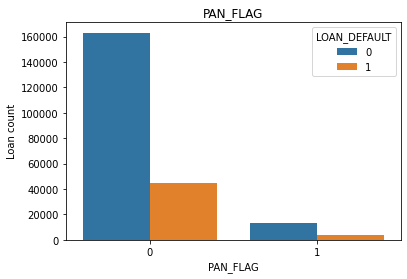

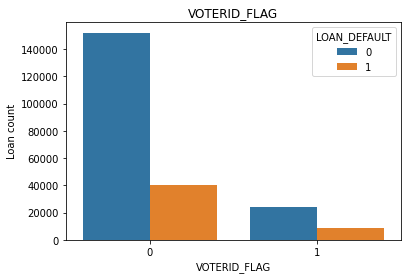

In [384]:
for feature in discrete_features[:6]:
    sns.countplot(data=df, x=feature, hue='LOAN_DEFAULT')
    plt.xlabel(feature)
    plt.ylabel('Loan count')
    plt.title(feature)
    plt.show()

In [385]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225493 entries, 0 to 233153
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UNIQUEID                             225493 non-null  int64  
 1   DISBURSED_AMOUNT                     225493 non-null  float64
 2   ASSET_COST                           225493 non-null  int64  
 3   LTV                                  225493 non-null  float64
 4   EMPLOYMENT_TYPE                      225493 non-null  object 
 5   DISBURSAL_DATE                       225493 non-null  int64  
 6   MOBILENO_AVL_FLAG                    225493 non-null  int64  
 7   AADHAR_FLAG                          225493 non-null  int64  
 8   PAN_FLAG                             225493 non-null  int64  
 9   VOTERID_FLAG                         225493 non-null  int64  
 10  DRIVING_FLAG                         225493 non-null  int64  
 11  PASSPORT_FLAG

In [386]:
plot={1:[111],2:[121,122],3:[131,132,133],4:[221,222,223,224],5:[231,232,233,234,235],6:[231,232,233,234,235,236]}

In [387]:
### Getting the continous features of the dataset
continuous_features=[feature for feature in numerical_features if feature not in discrete_features+['UNIQUEID']]
continuous_features

['DISBURSED_AMOUNT',
 'ASSET_COST',
 'LTV',
 'BRANCH_ID',
 'SUPPLIER_ID',
 'CURRENT_PINCODE_ID',
 'EMPLOYEE_CODE_ID',
 'PERFORM_CNS_SCORE',
 'PRI_NO_OF_ACCTS',
 'PRI_ACTIVE_ACCTS',
 'PRI_CURRENT_BALANCE',
 'PRI_SANCTIONED_AMOUNT',
 'PRI_DISBURSED_AMOUNT',
 'SEC_NO_OF_ACCTS',
 'SEC_CURRENT_BALANCE',
 'SEC_SANCTIONED_AMOUNT',
 'SEC_DISBURSED_AMOUNT',
 'PRIMARY_INSTAL_AMT',
 'SEC_INSTAL_AMT']

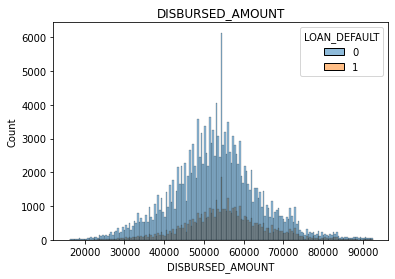

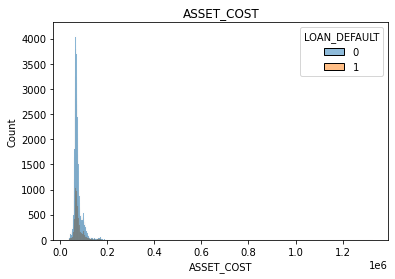

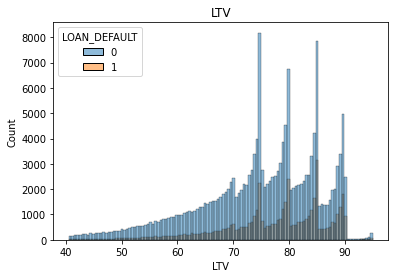

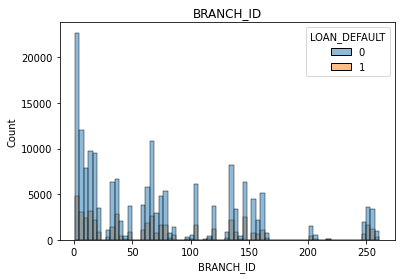

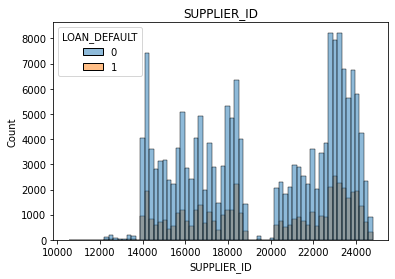

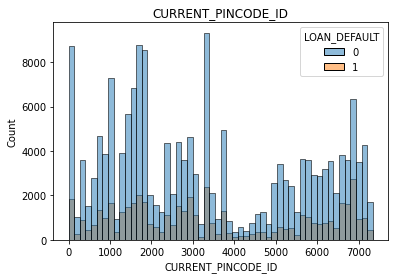

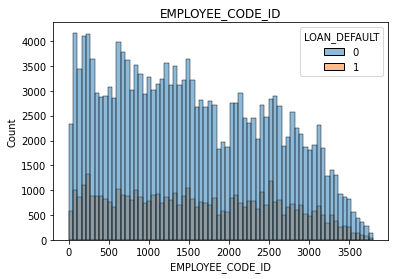

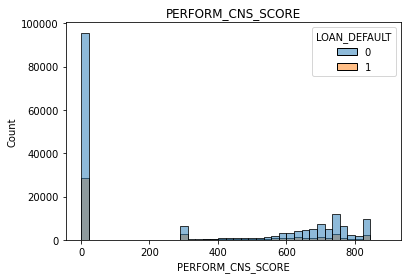

In [388]:
for feature in continuous_features[:8]:
    sns.histplot(data=df, x=feature, hue='LOAN_DEFAULT')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [389]:
df2=df.copy()

In [390]:
#df['EMPLOYMENT_TYPE'].unique()

In [391]:
df[df.LOAN_DEFAULT==0].isna().sum()
#missing data is assymetrically missinng

UNIQUEID                               0
DISBURSED_AMOUNT                       0
ASSET_COST                             0
LTV                                    0
BRANCH_ID                              0
SUPPLIER_ID                            0
MANUFACTURER_ID                        0
CURRENT_PINCODE_ID                     0
DATE_OF_BIRTH                          0
EMPLOYMENT_TYPE                        0
DISBURSAL_DATE                         0
STATE_ID                               0
EMPLOYEE_CODE_ID                       0
MOBILENO_AVL_FLAG                      0
AADHAR_FLAG                            0
PAN_FLAG                               0
VOTERID_FLAG                           0
DRIVING_FLAG                           0
PASSPORT_FLAG                          0
PERFORM_CNS_SCORE                      0
PERFORM_CNS_SCORE_DESCRIPTION          0
PRI_NO_OF_ACCTS                        0
PRI_ACTIVE_ACCTS                       0
PRI_OVERDUE_ACCTS                      0
PRI_CURRENT_BALA

In [392]:
#in original data LOAN_DEFAULT 0 to 1 ratio is 3.60
# inn missing dat 0:1 ratio is 3.66
# since ratio will be preserved after omitting missing data therefore we delete missing rows 

In [393]:
# df=df.EMPLOYMENT_TYPE.dropna()

In [394]:
df.isna().sum()

UNIQUEID                               0
DISBURSED_AMOUNT                       0
ASSET_COST                             0
LTV                                    0
BRANCH_ID                              0
SUPPLIER_ID                            0
MANUFACTURER_ID                        0
CURRENT_PINCODE_ID                     0
DATE_OF_BIRTH                          0
EMPLOYMENT_TYPE                        0
DISBURSAL_DATE                         0
STATE_ID                               0
EMPLOYEE_CODE_ID                       0
MOBILENO_AVL_FLAG                      0
AADHAR_FLAG                            0
PAN_FLAG                               0
VOTERID_FLAG                           0
DRIVING_FLAG                           0
PASSPORT_FLAG                          0
PERFORM_CNS_SCORE                      0
PERFORM_CNS_SCORE_DESCRIPTION          0
PRI_NO_OF_ACCTS                        0
PRI_ACTIVE_ACCTS                       0
PRI_OVERDUE_ACCTS                      0
PRI_CURRENT_BALA

In [395]:
# df[df.duplicated()]

<AxesSubplot:>

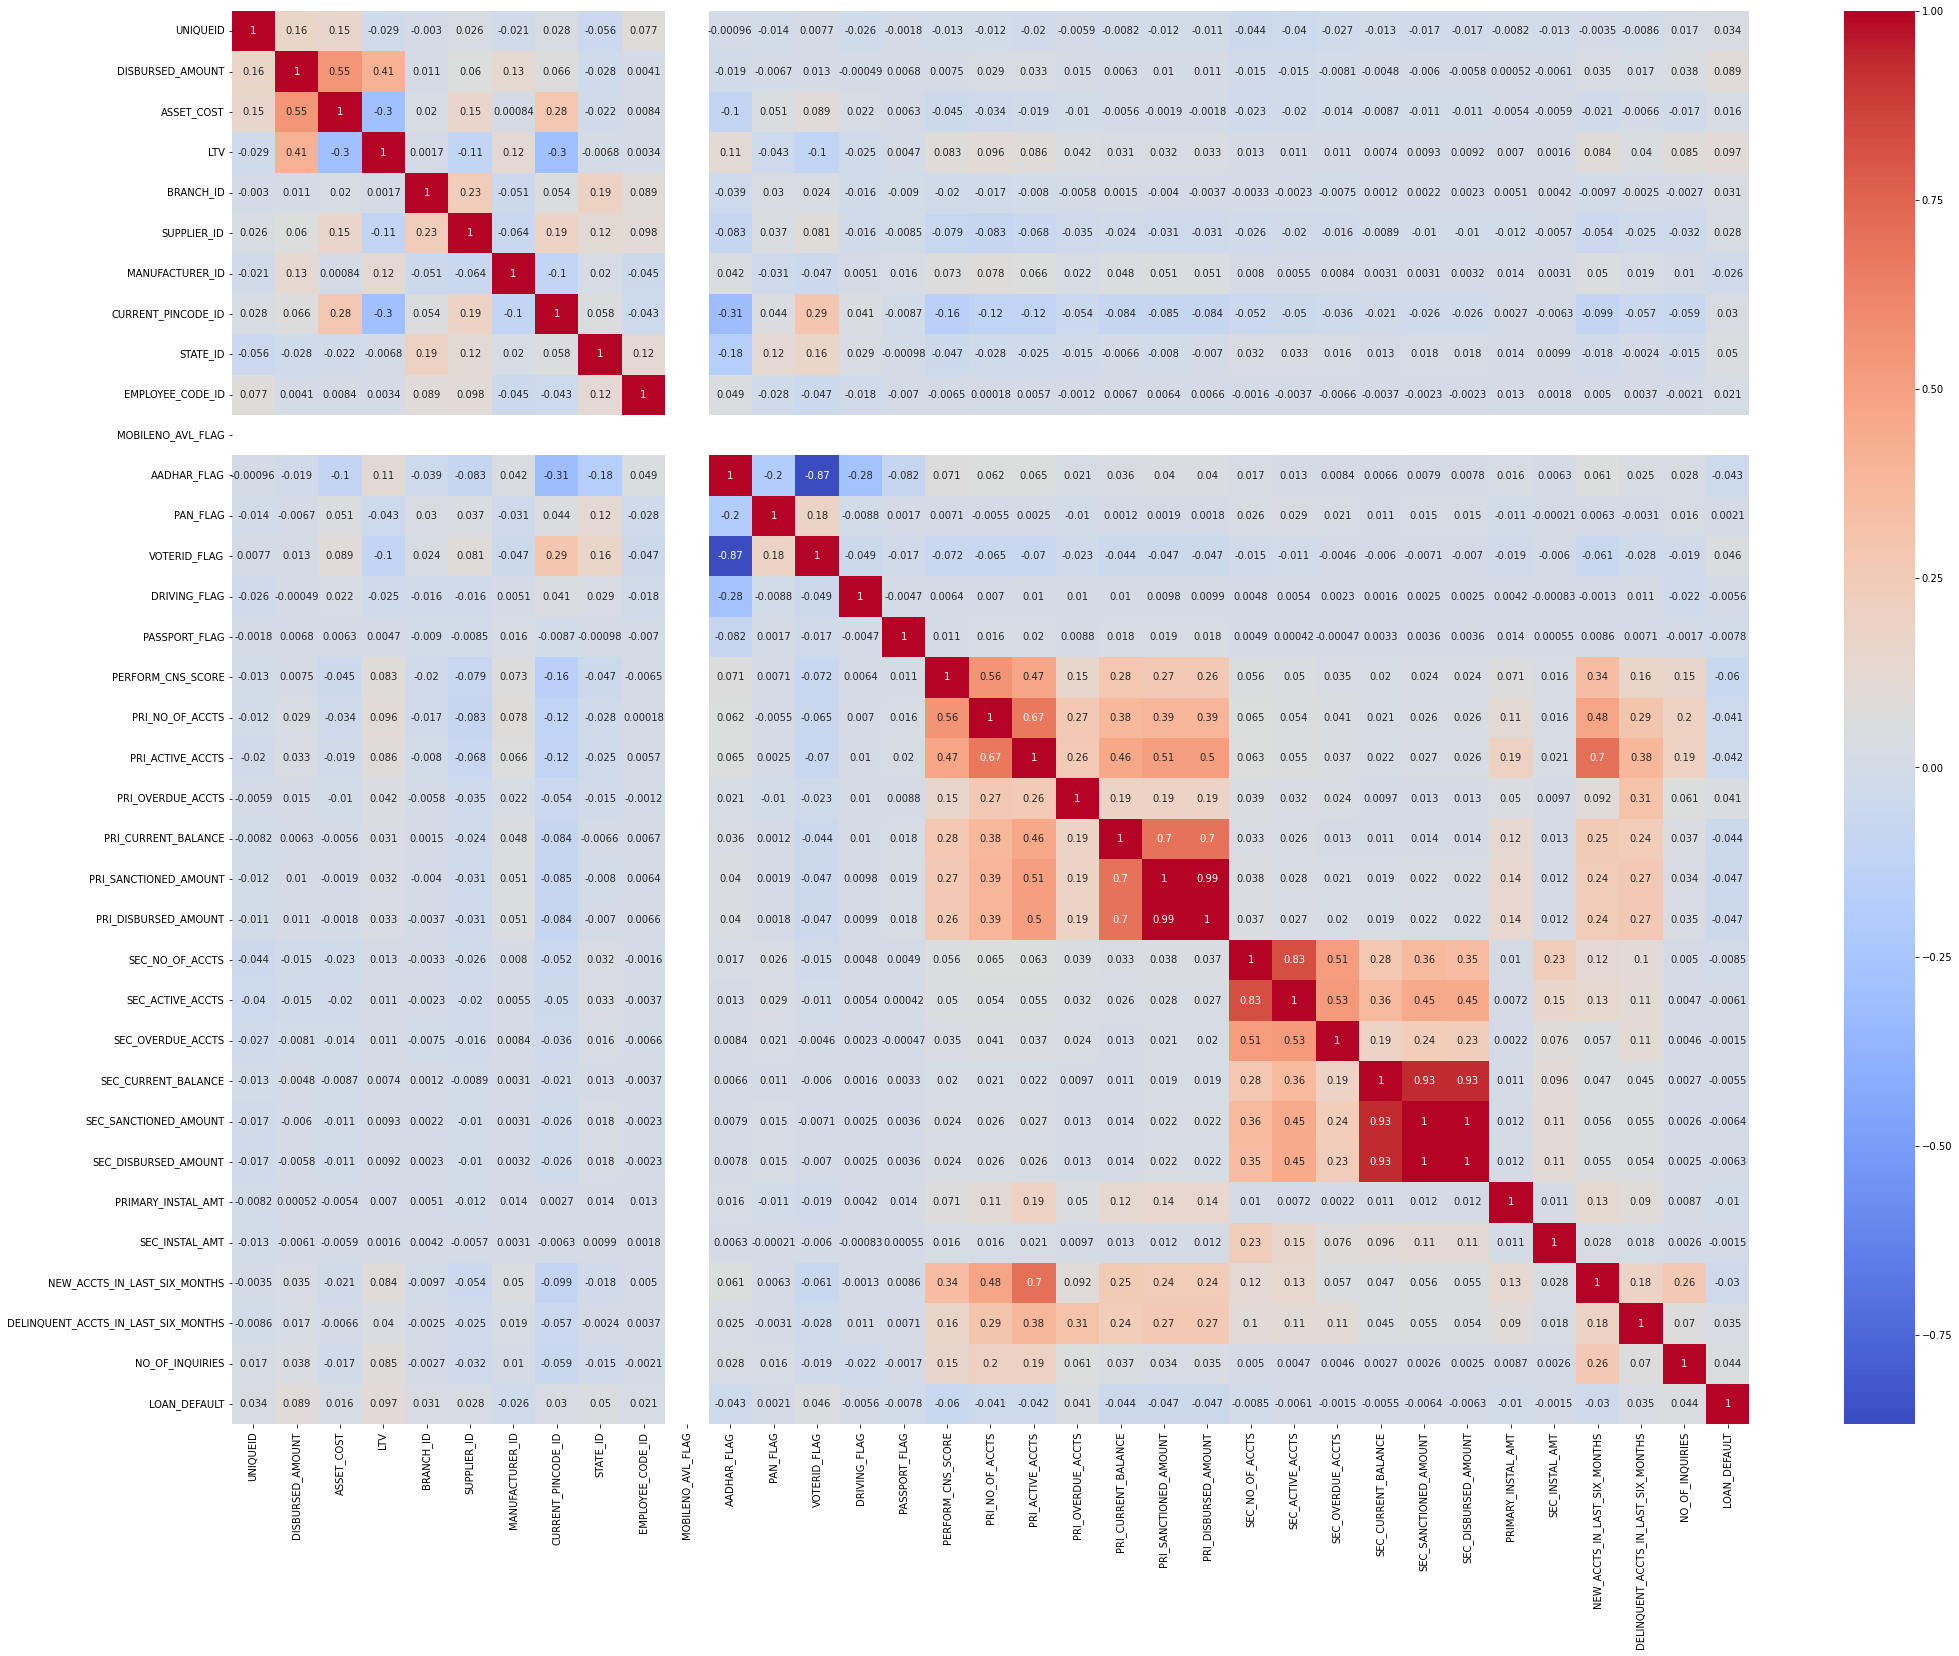

In [396]:
plt.figure(figsize=(34,26))
sns.heatmap(df2.corr(),annot=True, cmap="coolwarm")

In [397]:
#primary sactioned amount and primary disburused amount and secondARY a=sacntioned amount is very strongly correlated 

In [398]:
#mobile number is available for all fields

In [399]:
#MOBILENO_AVL_FLAG AADHAR_FLAG PAN_FLAG VOTERID_FLAG DRIVING_FLAG PASSPORT_FLAG are just for book=keeping purpose, so thy can be removed from data
#attributes removed 
#MOBILENO_AVL_FLAG AADHAR_FLAG PAN_FLAG VOTERID_FLAG DRIVING_FLAG PASSPORT_FLAG 
#PRI_SANCTIONED_AMOUNT PRI_DISBURSED_AMOUNT with 

In [400]:
train = train.drop([ 'UNIQUEID','PRI_SANCTIONED_AMOUNT' , 'SEC_SANCTIONED_AMOUNT', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG','DRIVING_FLAG','PASSPORT_FLAG'],axis=1)

In [401]:
train.rename(columns={'PRI_DISBURSED_AMOUNT': 'PRI_SANCTIONED_and_DISBURSED_AMOUNT'}, inplace=True)
train.rename(columns={'SEC_DISBURSED_AMOUNT': 'SEC_SANCTIONED_and_DISBURSED_AMOUNT'}, inplace=True)

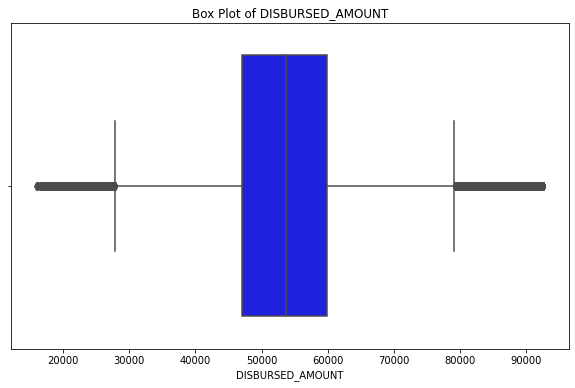

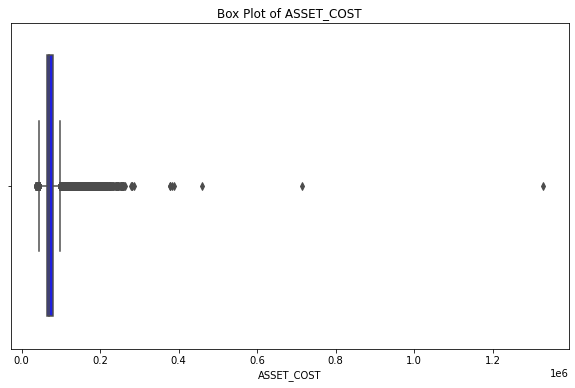

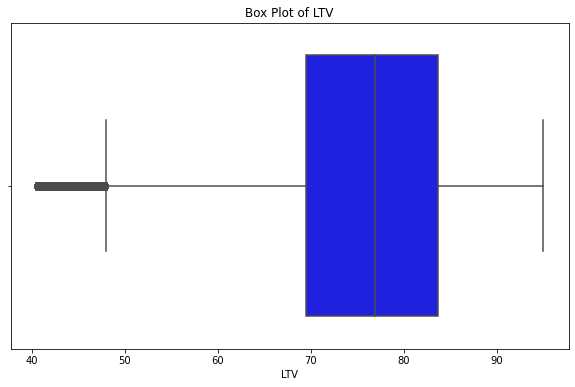

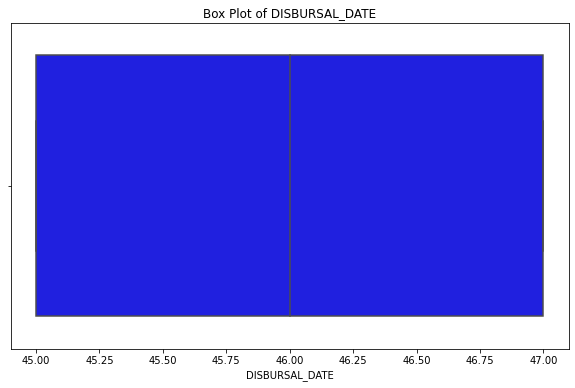

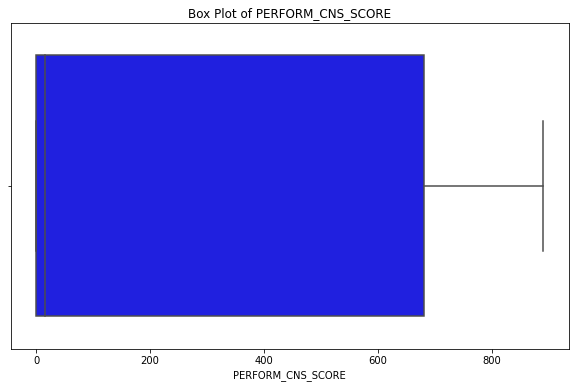

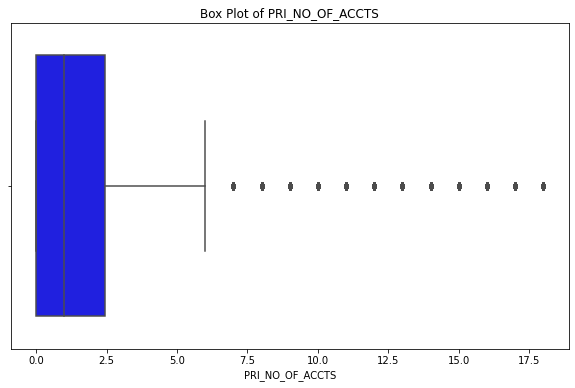

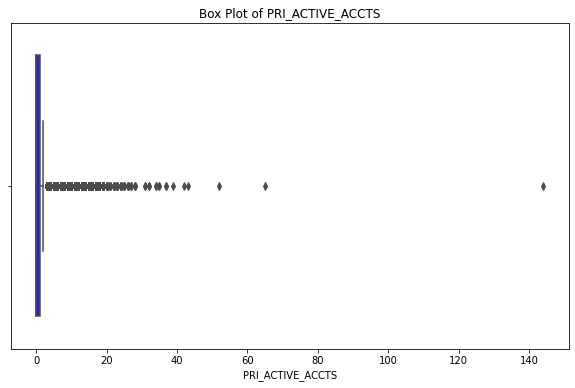

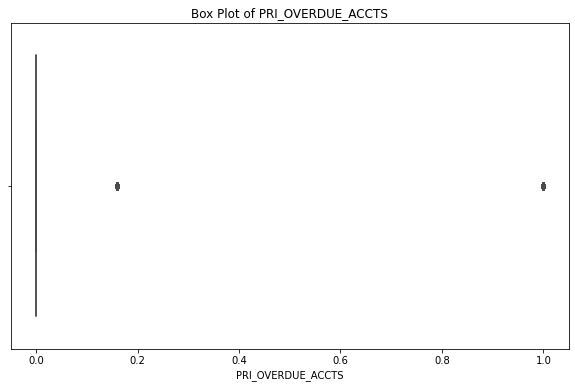

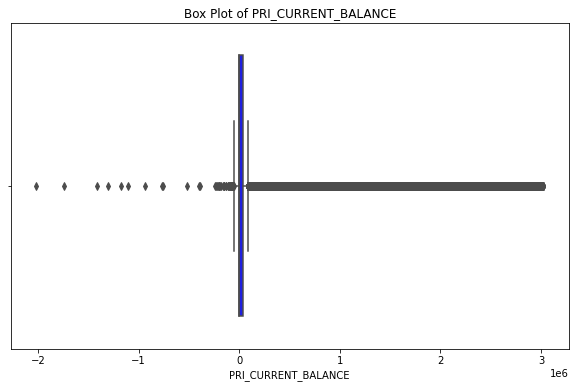

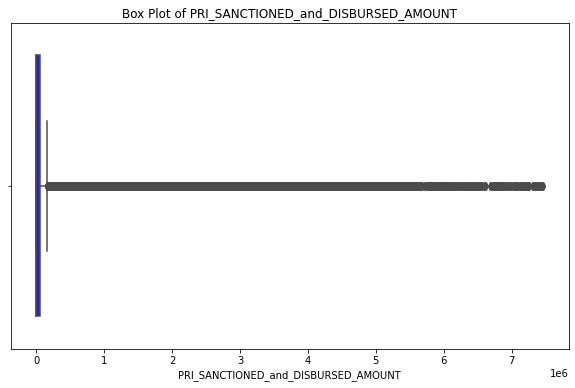

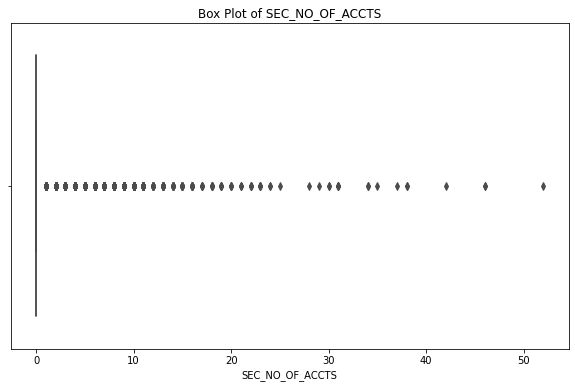

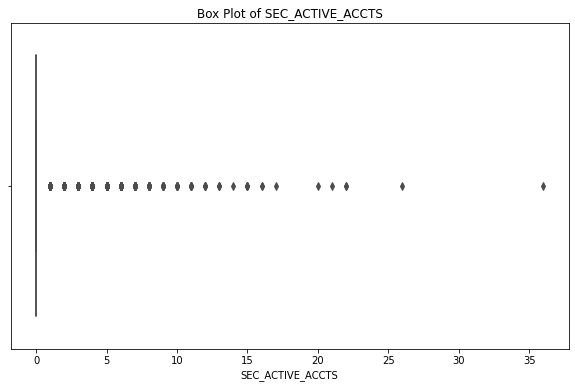

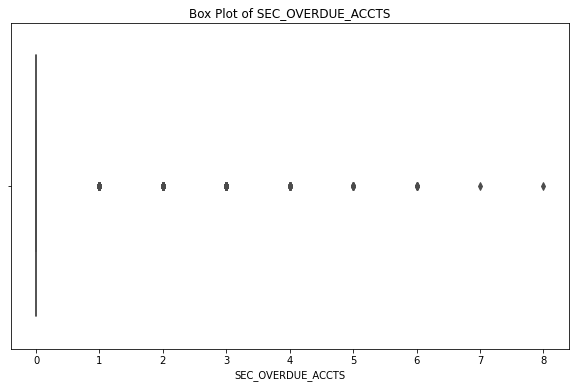

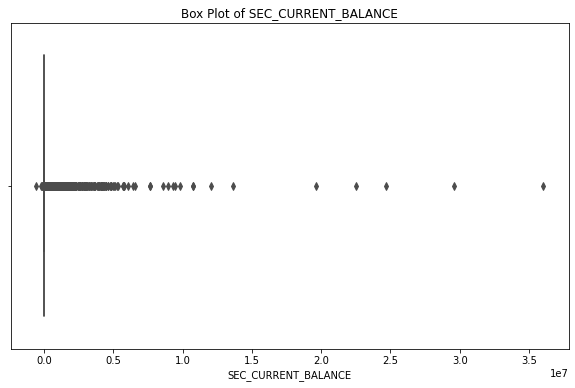

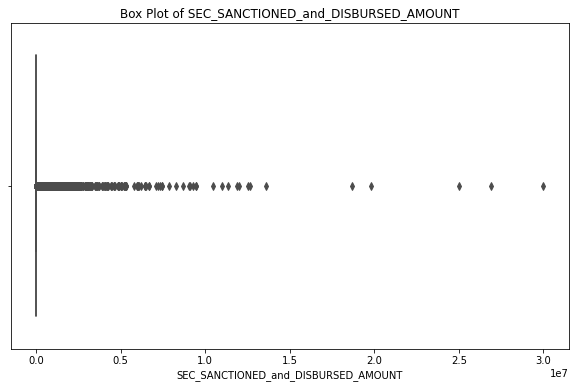

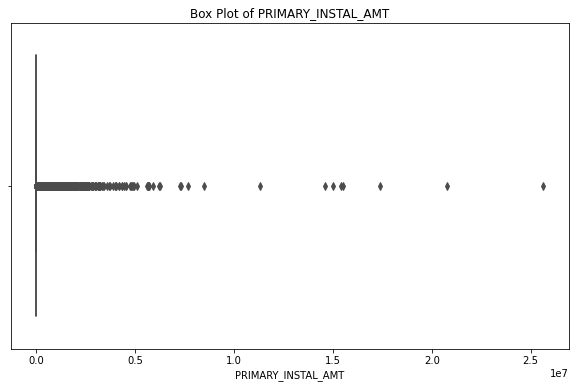

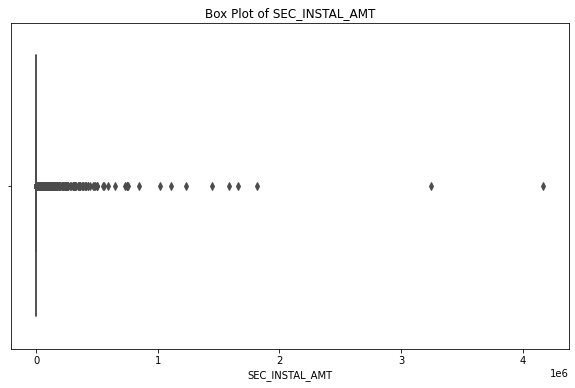

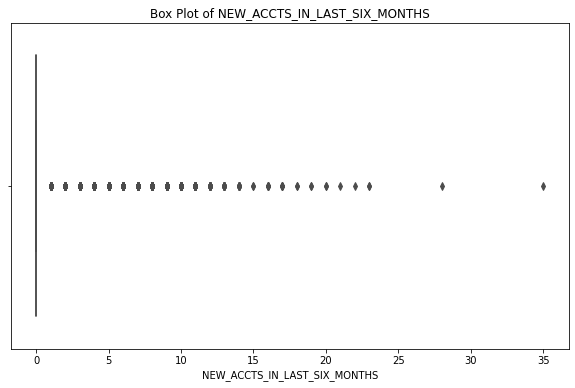

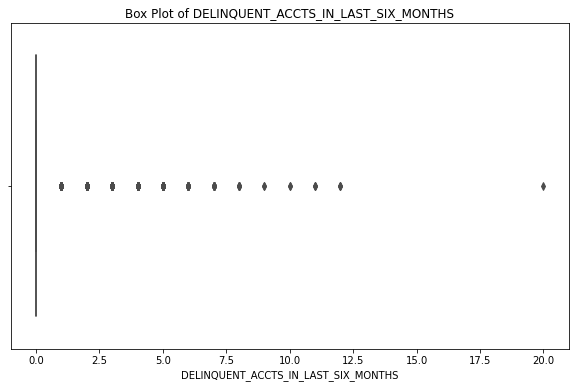

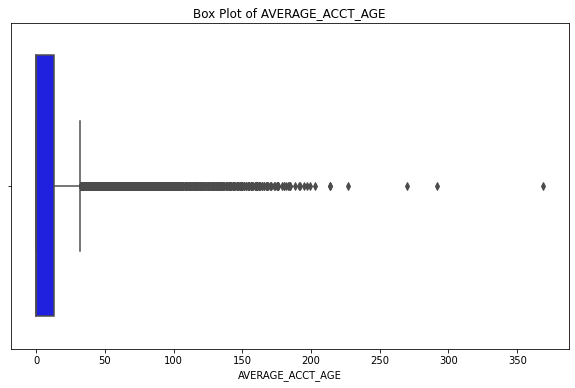

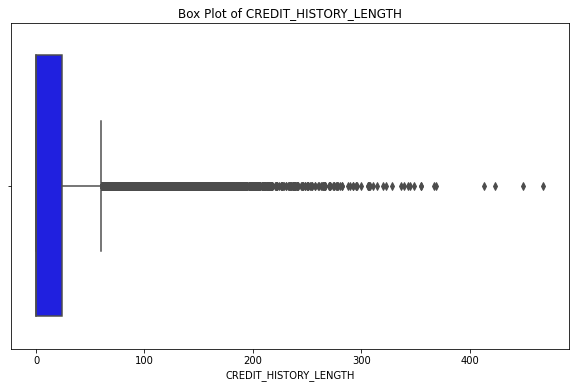

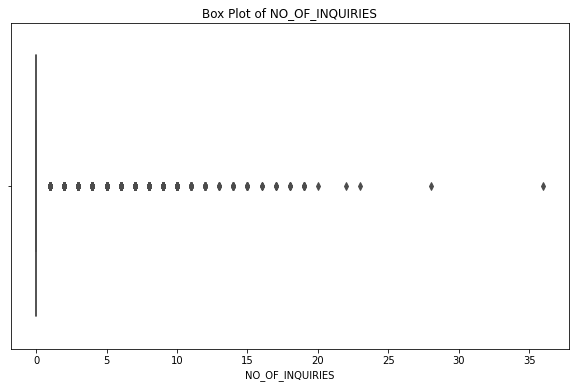

In [402]:
for column in boxplot_columns:
  plot_box(column,'blue',train)

In [403]:
# converting numerical data in str form to float
for i in range(len(boxplot_columns)):
  df2[boxplot_columns[i]] = list(np.float_(train[boxplot_columns[i]].to_list()))

In [404]:
# MinMax Normalization of numerical data
dfNormalized=pd.DataFrame()
for i in range(len(boxplot_columns)):
  col=train[boxplot_columns[i]].to_list()
  colSorted=sorted(df2[boxplot_columns[i]].to_list())
  NormList=[]
  for j in range(len(col)):
    a=100*(col[j]-colSorted[0])/(colSorted[-1]-colSorted[0])
    NormList.append(a)
  dfNormalized[boxplot_columns[i]]=NormList
dfNormalized.head()


,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES
0,45.222531,1.656406,90.001835,100.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,40.743205,2.209831,60.062374,50.0,67.191011,5.555556,0.694444,100.0,40.586499,0.67252,...,0.0,1.569752,0.0,0.007764,0.0,0.0,5.0,6.233062,4.914530,0.000000
2,48.745450,1.885516,90.148597,100.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,54.271213,2.253408,88.038892,0.0,34.269663,16.666667,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000121,0.0,0.0,0.0,2.168022,3.205128,2.777778
4,47.571143,1.803470,87.873785,50.0,0.000000,0.000000,0.000000,0.0,40.038974,0.00000,...,0.0,1.569752,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.777778


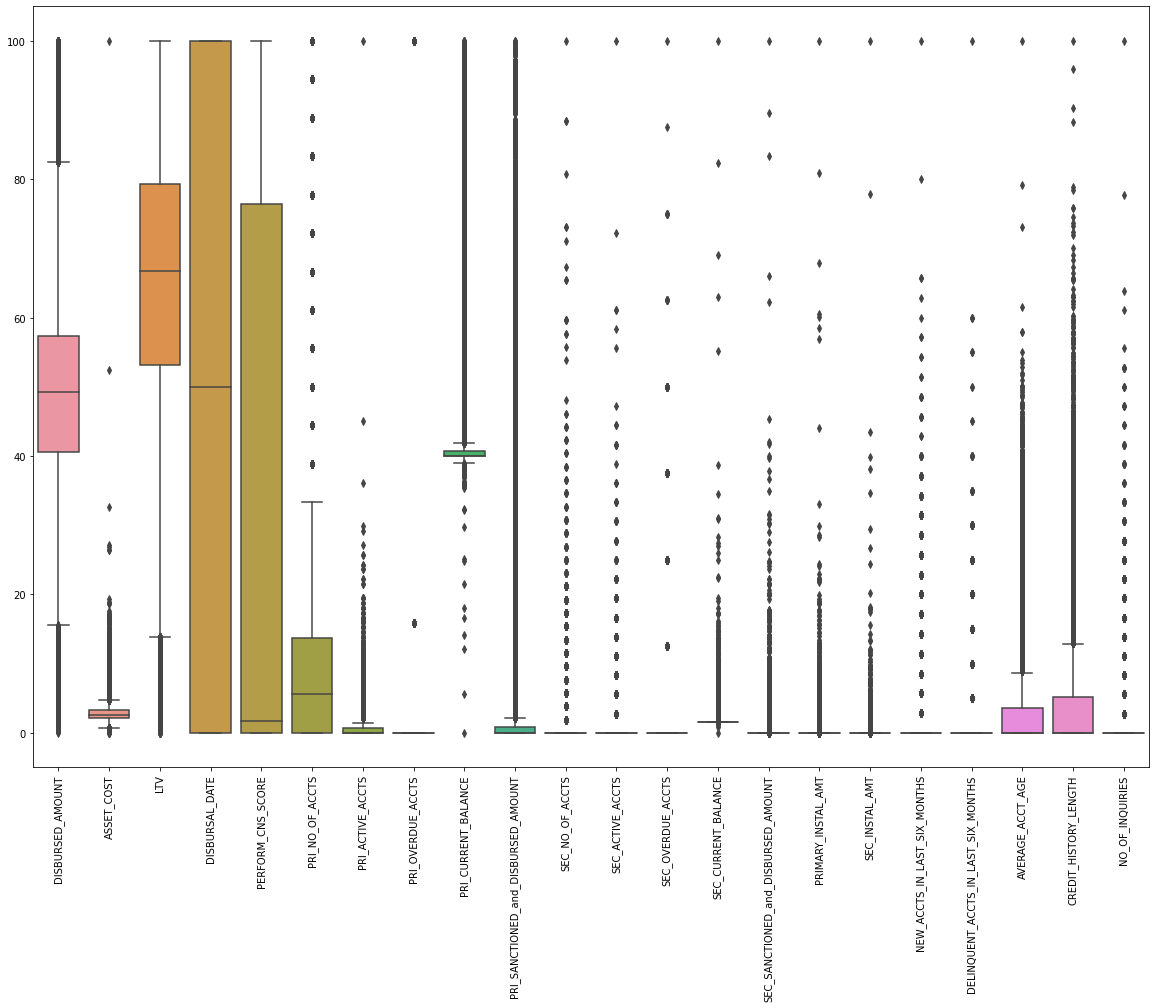

In [405]:
# boxplot of the MinMax Normalized values of numerical columns
fig = plt.figure(figsize=(20, 14))
plt.xticks(rotation=90)
sns.boxplot(data = dfNormalized)
plt.show()

In [406]:
train.describe()

,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
count,225493.000000,2.254930e+05,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,2.254930e+05,2.254930e+05,...,2.254930e+05,2.254930e+05,2.254930e+05,2.254930e+05,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000,225493.000000
mean,53620.859311,7.563113e+04,75.280560,45.872573,293.040449,2.001474,1.053767,0.091270,1.085117e+05,1.775055e+05,...,5.569682e+03,7.371104e+03,1.299246e+04,3.256845e+02,0.386602,0.098708,9.028302,16.453087,0.208845,0.217155
std,11097.451518,1.852758e+04,10.547173,0.834925,338.874784,3.275337,1.952015,0.281545,3.369341e+05,5.806243e+05,...,1.729281e+05,1.854703e+05,1.497084e+05,1.575617e+04,0.959668,0.386376,15.161620,28.676869,0.710085,0.412310
min,15919.000000,3.700000e+04,40.490000,45.000000,0.000000,0.000000,0.000000,0.000000,-2.018309e+06,0.000000e+00,...,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47069.000000,6.562500e+04,69.450000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53703.000000,7.080700e+04,76.890000,46.000000,15.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59897.000000,7.896600e+04,83.730000,47.000000,680.000000,2.462360,1.000000,0.000000,3.630000e+04,6.299000e+04,...,0.000000e+00,0.000000e+00,2.045000e+03,0.000000e+00,0.000000,0.000000,13.000000,24.000000,0.000000,0.000000
max,92560.000000,1.328954e+06,95.000000,47.000000,890.000000,18.000000,144.000000,1.000000,3.022552e+06,7.464458e+06,...,3.603285e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,369.000000,468.000000,36.000000,1.000000


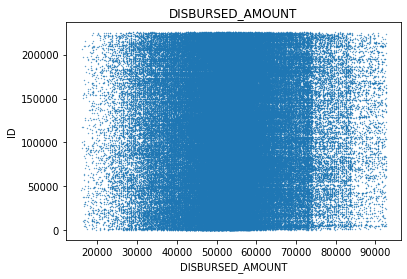

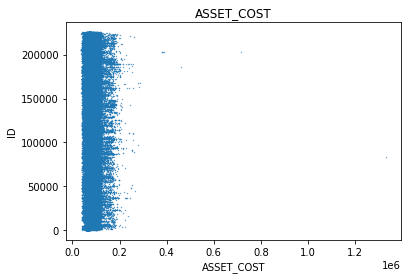

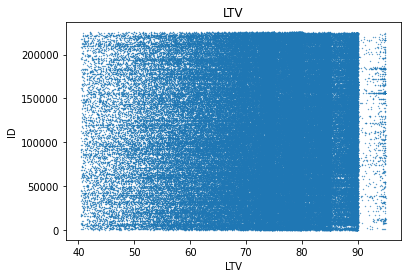

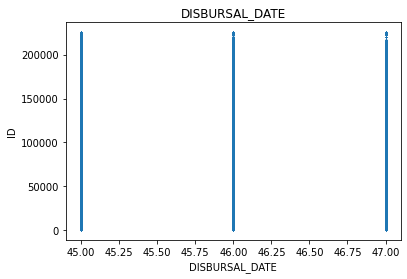

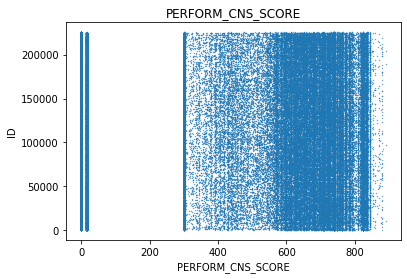

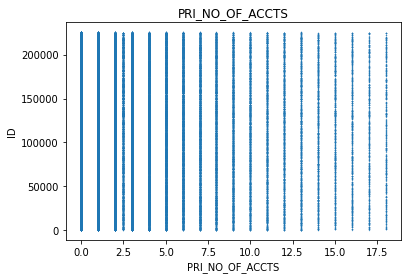

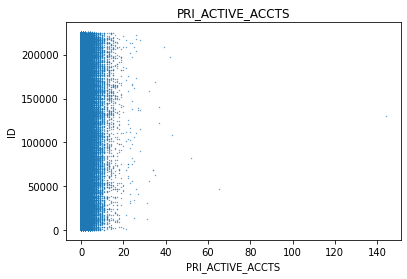

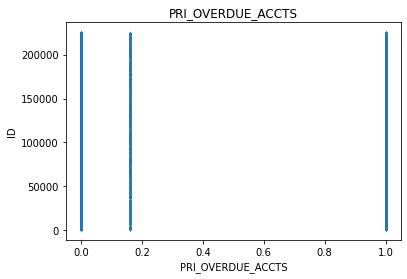

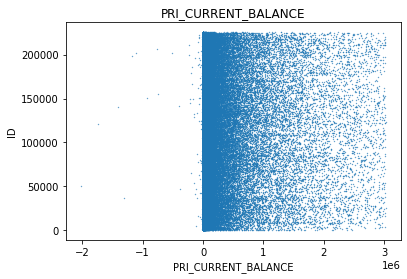

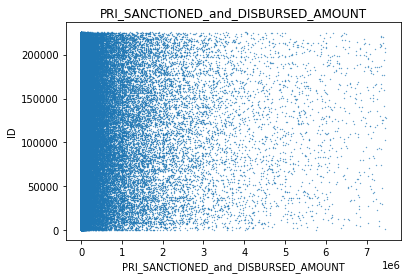

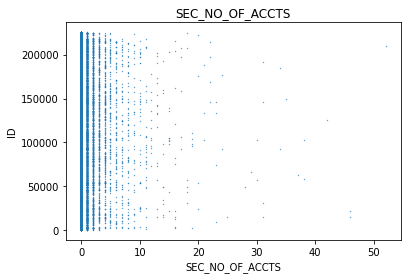

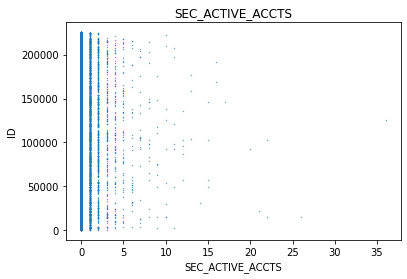

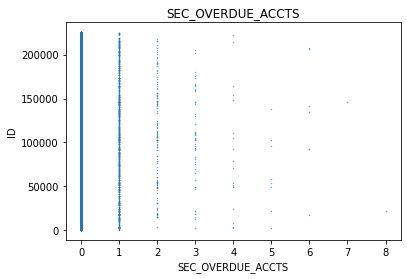

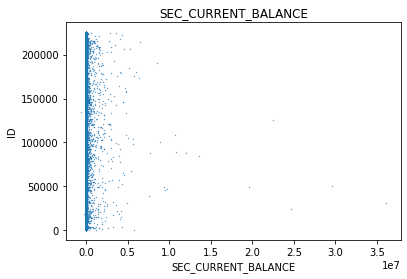

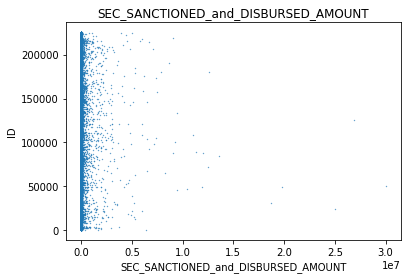

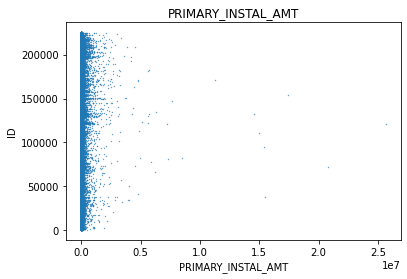

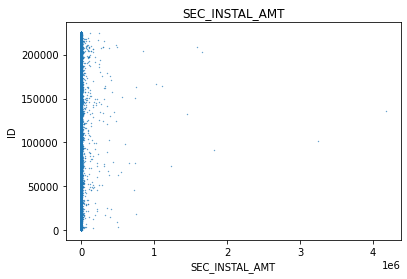

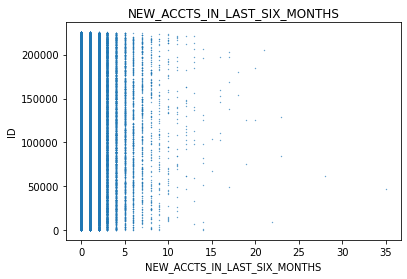

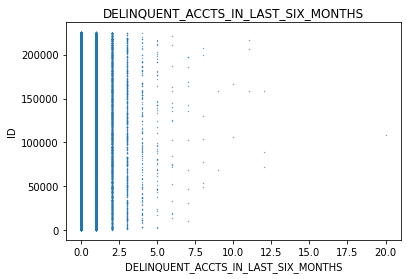

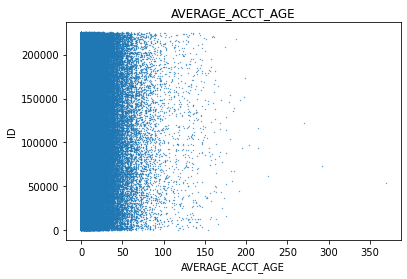

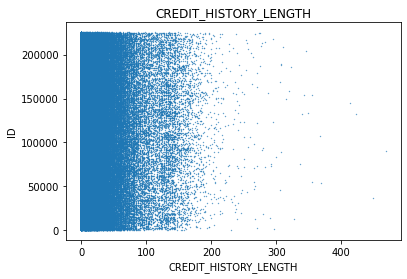

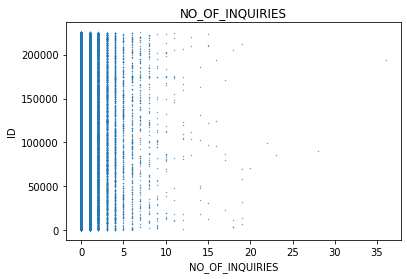

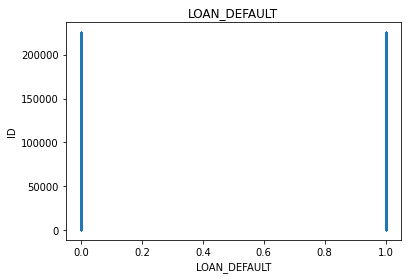

In [407]:
def scatterPlots():
    cols=train.columns
    UniqueID=[]
    for i in range(0,len(df2)):
      UniqueID.append(i+1)
    for col in cols:
        if (train[col].dtypes !='object'):
            fig1=plt.figure()
            ax1=plt.axes()
            plt.scatter(train[[col]],UniqueID,alpha=1,s=0.1)
            plt.title(col)
            ax1 = ax1.set(xlabel=col, ylabel='ID')
            plt.show()
scatterPlots()

In [408]:
# function to perform chiSquaredTest on 2 different attributes of data
def chiSquaredTest(listA,listB,labelA,labelB,labelC,labelD):
  X=[]
  a=0
  b=0
  c=0
  d=0
  for i in range(7043):
    m=int(listA[i])
    n=int(listB[i])
    if m==1 and n==1:
      a+=1
    elif m==0 and n==1:
      b+=1
    elif m==1 and n==0:
      c+=1
    elif m==0 and n==0:
      d+=1
  X.append(a)
  X.append(b)
  X.append(c)
  X.append(d)
  exp=[]
  o=(X[0]+X[2])*(X[0]+X[1])/7043
  p=(X[1]+X[3])*(X[0]+X[1])/7043
  q=(X[0]+X[2])*(X[2]+X[3])/7043
  r=(X[1]+X[3])*(X[2]+X[3])/7043
  exp.append(o)
  exp.append(p)
  exp.append(q)
  exp.append(r)
  box=[]
  boxExp=[]
  box.append([X[0],X[1],X[0]+X[1]])
  box.append([X[2],X[3],X[2]+X[3]])
  box.append([X[0]+X[2],X[1]+X[3],X[0]+X[1]+X[2]+X[3]])
  boxExp.append([exp[0],exp[1],exp[0]+exp[1]])
  boxExp.append([exp[2],exp[3],exp[2]+exp[3]])
  boxExp.append([exp[0]+exp[2],exp[1]+exp[3],exp[0]+exp[1]+exp[2]+exp[3]])
  boxDF=pd.DataFrame(box,columns=[labelA,labelB,"Total"],index=[labelC,labelD,"Total"])
  boxDFExp=pd.DataFrame(boxExp,columns=[labelA,labelB,"Total"],index=[labelC,labelD,"Total"])
  print("Calculated Table")
  print(boxDF)
  print()
  print("Expected Table")
  print(boxDFExp)
  chi2=0
  for i in range(4):
    chi2+=((X[i]-exp[i])**2)/exp[i]
  return chi2

In [409]:
df3=df.copy()
df3['EMPLOYMENT_TYPE'].replace(to_replace=['Salaried','Self employed'], value= [1,0], inplace = True)
df3['LOAN_DEFAULT'].replace(to_replace=['YES','NO'], value= [1,0], inplace = True)
# print(df3['EMPLOYMENT_TYPE'].to_list)
# print(df3['LOAN_DEFAULT'].to_list)
aa=(chiSquaredTest(df3['EMPLOYMENT_TYPE'].to_list(),df3['LOAN_DEFAULT'].to_list(),"Salaried","Self Employed","Loan Default","Loan Not Default"))
print()
print("Chi Squared value = ",aa)

Calculated Table
                  Salaried  Self Employed  Total
Loan Default           537            941   1478
Loan Not Default      2112           3453   5565
Total                 2649           4394   7043

Expected Table
                     Salaried  Self Employed   Total
Loan Default       555.902598     922.097402  1478.0
Loan Not Default  2093.097402    3471.902598  5565.0
Total             2649.000000    4394.000000  7043.0

Chi Squared value =  1.3038705107692794


In [410]:
train.head()

,DISBURSED_AMOUNT,ASSET_COST,LTV,EMPLOYMENT_TYPE,DISBURSAL_DATE,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,...,SEC_CURRENT_BALANCE,SEC_SANCTIONED_and_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,50578.0,58400,89.55,Salaried,47,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,47145.0,65550,73.23,Self employed,46,598,I-Medium Risk,1.0,1,1.0,...,0,0,1991,0,0,1,23,23,0,1
2,53278.0,61360,89.63,Self employed,47,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,57513.0,66113,88.48,Self employed,45,305,L-Very High Risk,3.0,0,0.0,...,0,0,31,0,0,0,8,15,1,1
4,52378.0,60300,88.39,Self employed,46,0,No Bureau History Available,0.0,0,0.0,...,0,0,0,0,0,0,0,0,1,1


In [411]:
train_dummy = pd.get_dummies(train, prefix_sep='_', drop_first=False)
train_dummy.head()
train_dummy.columns


Index(['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'DISBURSAL_DATE',
       'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_and_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_and_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE',
       'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT',
       'EMPLOYMENT_TYPE_Salaried', 'EMPLOYMENT_TYPE_Self employed',
       'PERFORM_CNS_SCORE_DESCRIPTION_A-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_B-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_C-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_D-Very Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_E-Low Risk',
       'PERFORM_CNS_SCORE_DESCRIPTION_F-Low Risk',
       'PERFORM_CNS_SCORE_DE

In [412]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

(225493, 44)

In [413]:
np.any(np.isnan(X))

False

In [414]:
X = X.fillna(0)
X.shape

(225493, 44)

In [415]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
# k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

**Random Forest**

In [416]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [417]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, rfc_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",(accuracy_score(y_test, rfc_pred))*100)

Confusion Matrix

          Positive  Negative
Positive     41506      2618
Negative     11082      1168

Accuracy  75.69801681626281


In [418]:
print("F1 Score ",f1_score(y_test, rfc_pred))
print("Recall Score ",recall_score(y_test, rfc_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_pred))

F1 Score  0.14567223746570215
Recall Score  0.0953469387755102
Balanced Accuracy Score  0.5180070746819261


In [419]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86     44124
           1       0.31      0.10      0.15     12250

    accuracy                           0.76     56374
   macro avg       0.55      0.52      0.50     56374
weighted avg       0.68      0.76      0.70     56374



**Logistic Regression**

In [420]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)

In [421]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logpred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logpred))*100)

Confusion Matrix

          Positive  Negative
Positive     44124         0
Negative     12250         0

Accuracy  100


In [422]:
print("F1 Score ",f1_score(y_test, logpred))
print("Recall Score ",recall_score(y_test, logpred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, logpred))

F1 Score  0.0
Recall Score  0.0
Balanced Accuracy Score  0.5


In [423]:
print(classification_report(y_test,logpred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.00      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.39      0.50      0.44     56374
weighted avg       0.61      0.78      0.69     56374



**Linear Regression**

In [424]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression() 
regr.fit(X_train, y_train)
regPred=regr.predict(X_test)

In [425]:
print("Confusion Matrix\n")
#using threshold of 0.5 below this as 0 and above it as 1
regPred = np.where(regPred<0.5,0,1)
confusionMatrix=confusion_matrix(y_test, regPred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, regPred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44099        25
Negative     12238        12

Accuracy  78.0


In [426]:
print("F1 Score ",f1_score(y_test, regPred))
print("Recall Score ",recall_score(y_test, regPred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, regPred))

F1 Score  0.0019532839586554893
Recall Score  0.0009795918367346938
Balanced Accuracy Score  0.5002065033791597


In [427]:
print(classification_report(y_test,regPred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.32      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.55      0.50      0.44     56374
weighted avg       0.68      0.78      0.69     56374



**Stochastic Gradient Descent**

In [428]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_train, y_train)

sgd_pred = sgd.predict(X_test)

In [429]:
print("Confusion Matrix\n")

confusionMatrix=confusion_matrix(y_test, sgd_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, sgd_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     20939     23185
Negative      4895      7355

Accuracy  50.0


In [430]:
print("F1 Score ",f1_score(y_test, sgd_pred))
print("Recall Score ",recall_score(y_test, sgd_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_pred))

F1 Score  0.34377190932460855
Recall Score  0.6004081632653061
Balanced Accuracy Score  0.5374785807714437


In [431]:
print(classification_report(y_test,sgd_pred))

              precision    recall  f1-score   support

           0       0.81      0.47      0.60     44124
           1       0.24      0.60      0.34     12250

    accuracy                           0.50     56374
   macro avg       0.53      0.54      0.47     56374
weighted avg       0.69      0.50      0.54     56374



**Naive Bayes**

In [432]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train, y_train)
nb_pred = nb.predict(X_test)

In [433]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, nb_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, nb_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive      6316     37808
Negative      1128     11122

Accuracy  31.0


In [434]:
print("F1 Score ",f1_score(y_test, nb_pred))
print("Recall Score ",recall_score(y_test, nb_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, nb_pred))

F1 Score  0.3635828702190258
Recall Score  0.9079183673469388
Balanced Accuracy Score  0.5255302107788995


In [435]:
print(classification_report(y_test,nb_pred))

              precision    recall  f1-score   support

           0       0.85      0.14      0.24     44124
           1       0.23      0.91      0.36     12250

    accuracy                           0.31     56374
   macro avg       0.54      0.53      0.30     56374
weighted avg       0.71      0.31      0.27     56374



**Decision Tree**

In [436]:
from sklearn.tree import DecisionTreeClassifier

#giving same output for both gini and entropy
dtree = DecisionTreeClassifier(random_state= 100).fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

In [437]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, dtree_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, dtree_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     34446      9678
Negative      9044      3206

Accuracy  67.0


In [438]:
print("F1 Score ",f1_score(y_test, dtree_pred))
print("Recall Score ",recall_score(y_test, dtree_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_pred))

F1 Score  0.2551125964828519
Recall Score  0.26171428571428573
Balanced Accuracy Score  0.5211889350790629


In [439]:
print(classification_report(y_test,dtree_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79     44124
           1       0.25      0.26      0.26     12250

    accuracy                           0.67     56374
   macro avg       0.52      0.52      0.52     56374
weighted avg       0.67      0.67      0.67     56374



**Artificial Neural Network**

In [440]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256), activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)

In [441]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, mlp_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, mlp_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44123         1
Negative     12250         0

Accuracy  78.0


In [442]:
print("F1 Score ",f1_score(y_test, mlp_pred))
print("Recall Score ",recall_score(y_test, mlp_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, mlp_pred))

F1 Score  0.0
Recall Score  0.0
Balanced Accuracy Score  0.4999886682984317


In [443]:
print(classification_report(y_test,mlp_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.00      0.00      0.00     12250

    accuracy                           0.78     56374
   macro avg       0.39      0.50      0.44     56374
weighted avg       0.61      0.78      0.69     56374



**AdaBoost**

In [444]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [445]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, ada_pred)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, ada_pred),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44014       110
Negative     12166        84

Accuracy  78.0


In [446]:
print("F1 Score ",f1_score(y_test, ada_pred))
print("Recall Score ",recall_score(y_test, ada_pred))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, ada_pred))

F1 Score  0.013500482160077145
Recall Score  0.006857142857142857
Balanced Accuracy Score  0.5021820842560576


In [447]:
print(classification_report(y_test,ada_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.43      0.01      0.01     12250

    accuracy                           0.78     56374
   macro avg       0.61      0.50      0.45     56374
weighted avg       0.71      0.78      0.69     56374



**K-Fold Cross Validation**

Random Forest

In [448]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

a=[]
b=[]
model = RandomForestClassifier()
for i in range(2,15):
    cv = KFold(n_splits=i, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print(i,mean(scores))
    a.append(mean(scores))
    b.append(i)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


2 0.7644735423211861


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


3 0.7637817158332298


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

4 0.7637876430699138


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

5 0.7640892105518654


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

6 0.7640537321486327


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

7 0.7640655758583459


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

8 0.7637048740277166


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

9 0.7635570219786068


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

10 0.7634979386908824


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

11 0.7638881643411559


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

12 0.7636161826588285


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

13 0.7638763619783087


/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: 

14 0.7635393271495609


Maximum Accuracy  0.7644735423211861
Corresponding K value  2


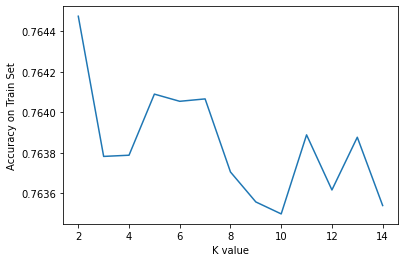

In [449]:
plt.plot(b,a)
plt.xlabel("K value")
plt.ylabel("Accuracy on Train Set")

print("Maximum Accuracy ",max(a))
ind=a.index(max(a))
print("Corresponding K value ",b[ind])

In [450]:
cv = KFold(n_splits=b[ind], random_state=1, shuffle=True)
model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [451]:
from sklearn.model_selection import cross_val_predict

pred=cross_val_predict(model,X_test,y_test)
scores_test=cross_val_score(model,X_test,y_test,cv=b[ind])

In [452]:
print(mean(scores_test))
model.fit(X_train, y_train)
logRegKFold=model.predict(X_test)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

0.7655834249831482

Accuracy  76.0


In [453]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logRegKFold)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

Confusion Matrix

          Positive  Negative
Positive     42087      2037
Negative     11308       942

Accuracy  76.0


In [454]:
print(classification_report(y_test,logRegKFold))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     44124
           1       0.32      0.08      0.12     12250

    accuracy                           0.76     56374
   macro avg       0.55      0.52      0.49     56374
weighted avg       0.69      0.76      0.70     56374



Ada Boost

In [455]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

a=[]
b=[]
model = AdaBoostClassifier()
for i in range(2,15):
    cv = KFold(n_splits=i, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print(i,mean(scores))
    a.append(mean(scores))
    b.append(i)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 0.7824076565367586


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 0.7826855646024397


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

4 0.7826678472337976


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

5 0.7825791544165126


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

6 0.7826146125657849


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

7 0.7825614293988858


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

8 0.7826205538637956


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

9 0.7826264346406968


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

10 0.7825673574778795


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

11 0.7826382669082317


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

12 0.7826560165129561


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

13 0.7825791537186162


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

14 0.7825318765345111


Maximum Accuracy  0.7826855646024397
Corresponding K value  3


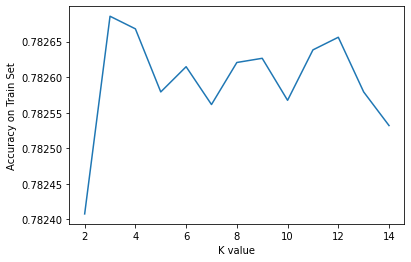

In [456]:
plt.plot(b,a)
plt.xlabel("K value")
plt.ylabel("Accuracy on Train Set")

print("Maximum Accuracy ",max(a))
ind=a.index(max(a))
print("Corresponding K value ",b[ind])

In [457]:
cv = KFold(n_splits=b[ind], random_state=1, shuffle=True)
model = AdaBoostClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [458]:
from sklearn.model_selection import cross_val_predict

pred=cross_val_predict(model,X_test,y_test)
scores_test=cross_val_score(model,X_test,y_test,cv=b[ind])

In [459]:
print(mean(scores_test))
model.fit(X_train, y_train)
logRegKFold=model.predict(X_test)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

0.7819916937582707

Accuracy  78.0


In [460]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logRegKFold)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44001       123
Negative     12153        97

Accuracy  78.0


In [461]:
print(classification_report(y_test,logRegKFold))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.44      0.01      0.02     12250

    accuracy                           0.78     56374
   macro avg       0.61      0.50      0.45     56374
weighted avg       0.71      0.78      0.69     56374



Logistic Regression

In [462]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

a=[]
b=[]
model = LogisticRegression()
for i in range(2,15):
    cv = KFold(n_splits=i, random_state=1, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print(i,mean(scores))
    a.append(mean(scores))
    b.append(i)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2 0.7828629556688365


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3 0.7828866064723656


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

4 0.7828925394801032


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

5 0.7828866280498419


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

6 0.7828866099703256


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

7 0.7828866427549932


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

8 0.7828866371182894


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

9 0.7828866064723656


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

10 0.7828866580825756


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

11 0.7828866104751968


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

12 0.7828866257763687


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

13 0.7828866322469256


/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

14 0.7828866546966936


/home/sahil/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Maximum Accuracy  0.7828925394801032
Corresponding K value  4


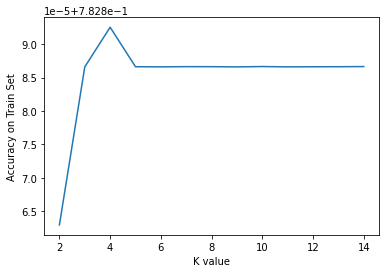

In [463]:
plt.plot(b,a)
plt.xlabel("K value")
plt.ylabel("Accuracy on Train Set")

print("Maximum Accuracy ",max(a))
ind=a.index(max(a))
print("Corresponding K value ",b[ind])

In [464]:
cv = KFold(n_splits=b[ind], random_state=1, shuffle=True)
model = AdaBoostClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sahil/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

In [465]:
from sklearn.model_selection import cross_val_predict

pred=cross_val_predict(model,X_test,y_test)
scores_test=cross_val_score(model,X_test,y_test,cv=b[ind])

In [466]:
print(mean(scores_test))
model.fit(X_train, y_train)
logRegKFold=model.predict(X_test)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

0.7820804020940947

Accuracy  78.0


In [467]:
print("Confusion Matrix\n")
confusionMatrix=confusion_matrix(y_test, logRegKFold)
ConfusionMatrixDF = pd.DataFrame(confusionMatrix,columns=["Positive","Negative"],index=["Positive","Negative"])
print(ConfusionMatrixDF)
print("\nAccuracy ",round(accuracy_score(y_test, logRegKFold),2)*100)

Confusion Matrix

          Positive  Negative
Positive     44001       123
Negative     12153        97

Accuracy  78.0


In [468]:
print(classification_report(y_test,logRegKFold))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     44124
           1       0.44      0.01      0.02     12250

    accuracy                           0.78     56374
   macro avg       0.61      0.50      0.45     56374
weighted avg       0.71      0.78      0.69     56374



In [469]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodel.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfc.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Random Forest
y_pred_proba3 = rfc.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nb.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtree.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlp.predict_proba(X_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = ada.predict_proba(X_test)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

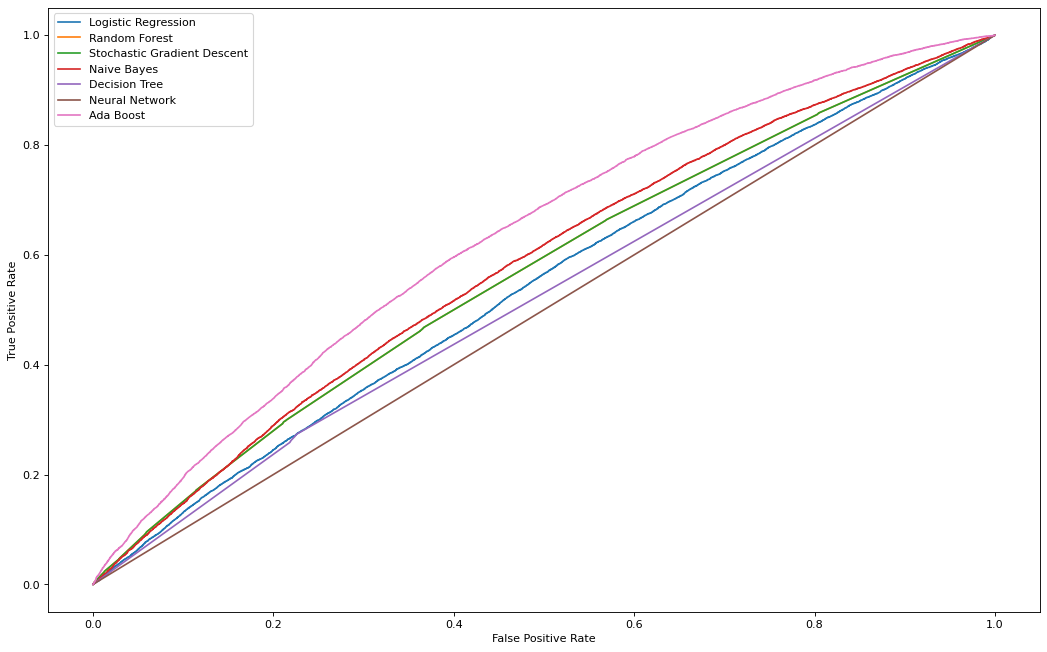

In [470]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1,tpr1,label='Logistic Regression')
plt.plot(fpr2,tpr2,label='Random Forest')
plt.plot(fpr3,tpr3,label='Stochastic Gradient Descent')
plt.plot(fpr4,tpr4,label='Naive Bayes')
plt.plot(fpr5,tpr5,label='Decision Tree')
plt.plot(fpr6,tpr6,label='Neural Network')
plt.plot(fpr7,tpr7,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [471]:
X

,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,PERFORM_CNS_SCORE_DESCRIPTION_K-High Risk,PERFORM_CNS_SCORE_DESCRIPTION_L-Very High Risk,PERFORM_CNS_SCORE_DESCRIPTION_M-Very High Risk,PERFORM_CNS_SCORE_DESCRIPTION_No Bureau History Available,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Sufficient History Not Available
0,50578.0,58400,89.55,47,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,47145.0,65550,73.23,46,598,1.0,1,1.0,27600.0,50200.0,...,0,0,0,0,0,0,0,0,0,0
2,53278.0,61360,89.63,47,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,57513.0,66113,88.48,45,305,3.0,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,52378.0,60300,88.39,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213.0,105405,60.72,45,735,4.0,3,0.0,390443.0,416133.0,...,0,0,0,0,0,0,0,0,0,0
233150,73651.0,100600,74.95,45,825,1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
233151,33484.0,71212,48.45,45,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
233152,34259.0,73286,49.10,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


**SMOTE**

In [472]:
from imblearn.over_sampling import SMOTE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# sm = SMOTE(random_state=27)
# X_train, y_train = sm.fit_resample(X_train, y_train)

sm = SMOTE(random_state=27)
X_smote,y_smote=sm.fit_resample(X_train,y_train)

Stochiastic Gradient Descent

In [473]:
from sklearn.linear_model import SGDClassifier

# train model
sgdSMPOTE = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_smote, y_smote)

# predict on test set
sgd_predSMOTE = sgdSMPOTE.predict(X_test)
print(confusion_matrix(y_test, sgd_predSMOTE))
print(round(accuracy_score(y_test, sgd_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, sgd_predSMOTE))
print("F1 Score ",f1_score(y_test, sgd_predSMOTE))
print("Recall Score ",recall_score(y_test, sgd_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_predSMOTE))


[[25271 18853]
 [ 7506  4744]]
53.0
Accuracy of model  0.5324262958101252
F1 Score  0.2646804474572489
Recall Score  0.38726530612244897
Balanced Accuracy Score  0.4799960833939232


Decision Tree

In [474]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtreeSMOTE = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_smote, y_smote)

# predict on test set
dtree_predSMOTE = dtreeSMOTE.predict(X_test)
print(confusion_matrix(y_test, dtree_predSMOTE))
print(round(accuracy_score(y_test, dtree_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, dtree_predSMOTE))
print("F1 Score ",f1_score(y_test, dtree_predSMOTE))
print("Recall Score ",recall_score(y_test, dtree_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_predSMOTE))


[[37087  7037]
 [ 9724  2526]]
70.0
Accuracy of model  0.7026820874871395
F1 Score  0.23160500618896984
Recall Score  0.20620408163265305
Balanced Accuracy Score  0.5233608568801467


Random Forest

In [475]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfcSMOTE = RandomForestClassifier(n_estimators=10).fit(X_smote, y_smote)

# predict on test set
rfc_predSMOTE = rfcSMOTE.predict(X_test)
print(confusion_matrix(y_test, rfc_predSMOTE))
print(round(accuracy_score(y_test, rfc_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_predSMOTE))
print("F1 Score ",f1_score(y_test, rfc_predSMOTE))
print("Recall Score ",recall_score(y_test, rfc_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_predSMOTE))

[[38684  5440]
 [10066  2184]]
72.0
Accuracy of model  0.7249441231773512
F1 Score  0.2197846432524907
Recall Score  0.1782857142857143
Balanced Accuracy Score  0.5274984006112644


Logistic Regression

In [476]:
from sklearn.linear_model import LogisticRegression

# train model
logmodelSMOTE = LogisticRegression().fit(X_smote,y_smote)
logpredSMOTE = logmodelSMOTE.predict(X_test)

print(confusion_matrix(y_test, logpredSMOTE))
print(round(accuracy_score(y_test, logpredSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, logpredSMOTE))
print("F1 Score ",f1_score(y_test, logpredSMOTE))
print("Recall Score ",recall_score(y_test, logpredSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, logpredSMOTE))

[[21427 22697]
 [ 4568  7682]]
52.0
Accuracy of model  0.5163550572959166
F1 Score  0.36041192615355744
Recall Score  0.6271020408163265
Balanced Accuracy Score  0.556355389912288


Naive Bayes

In [477]:
from sklearn.naive_bayes import GaussianNB

nbSMOTE = GaussianNB().fit(X_smote, y_smote)
nb_predSMOTE = nbSMOTE.predict(X_test)

print(confusion_matrix(y_test, nb_predSMOTE))
print(round(accuracy_score(y_test, nb_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, nb_predSMOTE))
print("F1 Score ",f1_score(y_test, nb_predSMOTE))
print("Recall Score ",recall_score(y_test, nb_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, nb_predSMOTE))

[[ 3581 40543]
 [  626 11624]]
27.0
Accuracy of model  0.26971653599176926
F1 Score  0.3608985205768664
Recall Score  0.9488979591836735
Balanced Accuracy Score  0.5150278029079459


**Neural Network**

In [478]:
from sklearn.neural_network import MLPClassifier

mlpSMOTE = MLPClassifier( activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlpSMOTE.fit(X_smote,y_smote)
mlp_predSMOTE = mlpSMOTE.predict(X_test)

print(confusion_matrix(y_test, mlp_predSMOTE))
print(round(accuracy_score(y_test, mlp_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, mlp_predSMOTE))
print("F1 Score ",f1_score(y_test, mlp_predSMOTE))
print("Recall Score ",recall_score(y_test, mlp_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, mlp_predSMOTE))

[[    1 44123]
 [    0 12250]]
22.0
Accuracy of model  0.217316493418952
F1 Score  0.3570231555017997
Recall Score  1.0
Balanced Accuracy Score  0.5000113317015683


**Ada Boost**

In [479]:
from sklearn.ensemble import AdaBoostClassifier

adaSMOTE = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
adaSMOTE.fit(X_smote, y_smote)
ada_predSMOTE = adaSMOTE.predict(X_test)

print(confusion_matrix(y_test, ada_predSMOTE))
print(round(accuracy_score(y_test, ada_predSMOTE),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, ada_predSMOTE))
print("F1 Score ",f1_score(y_test, ada_predSMOTE))
print("Recall Score ",recall_score(y_test, ada_predSMOTE))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, ada_predSMOTE))

[[39835  4289]
 [10305  1945]]
74.0
Accuracy of model  0.7411217937347004
F1 Score  0.21045228305561567
Recall Score  0.15877551020408162
Balanced Accuracy Score  0.53078608707557


In [480]:
y_test

,LOAN_DEFAULT
6271,0
66793,1
34343,0
7355,0
47192,0
...,...
145245,0
140481,0
210585,0
15398,0


In [481]:
X_test

,DISBURSED_AMOUNT,ASSET_COST,LTV,DISBURSAL_DATE,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_and_DISBURSED_AMOUNT,...,PERFORM_CNS_SCORE_DESCRIPTION_K-High Risk,PERFORM_CNS_SCORE_DESCRIPTION_L-Very High Risk,PERFORM_CNS_SCORE_DESCRIPTION_M-Very High Risk,PERFORM_CNS_SCORE_DESCRIPTION_No Bureau History Available,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS_SCORE_DESCRIPTION_Not Scored: Sufficient History Not Available
6271,53639.0,76076,73.61,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
66793,66242.0,115864,59.00,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
34343,57997.0,101029,60.38,45,387,4.0,2,1.0,271307.0,361000.0,...,1,0,0,0,0,0,0,0,0,0
7355,52052.0,88204,60.42,45,643,1.0,1,0.0,15464.0,97500.0,...,0,0,0,0,0,0,0,0,0,0
47192,55500.0,71469,80.45,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145245,46649.0,64611,77.39,47,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
140481,44094.0,65794,67.94,47,625,1.0,1,0.0,3442.0,45442.0,...,0,0,0,0,0,0,0,0,0,0
210585,59213.0,73294,83.23,47,17,1.0,1,0.0,61000.0,61000.0,...,0,0,0,0,0,0,0,1,0,0
15398,50078.0,72390,70.45,46,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [482]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodelSMOTE.predict_proba(X_test)[::,1]
fpr1S, tpr1S, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfcSMOTE.predict_proba(X_test)[::,1]
fpr2S, tpr2S, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Stochastic Gradient Descent
y_pred_proba3 = sgdSMPOTE.predict_proba(X_test)[::,1]
fpr3S, tpr3S, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nbSMOTE.predict_proba(X_test)[::,1]
fpr4S, tpr4S, _ = metrics.roc_curve(y_test,y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtreeSMOTE.predict_proba(X_test)[::,1]
fpr5S, tpr5S, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlpSMOTE.predict_proba(X_test)[::,1]
fpr6S, tpr6S, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = adaSMOTE.predict_proba(X_test)[::,1]
fpr7S, tpr7S, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

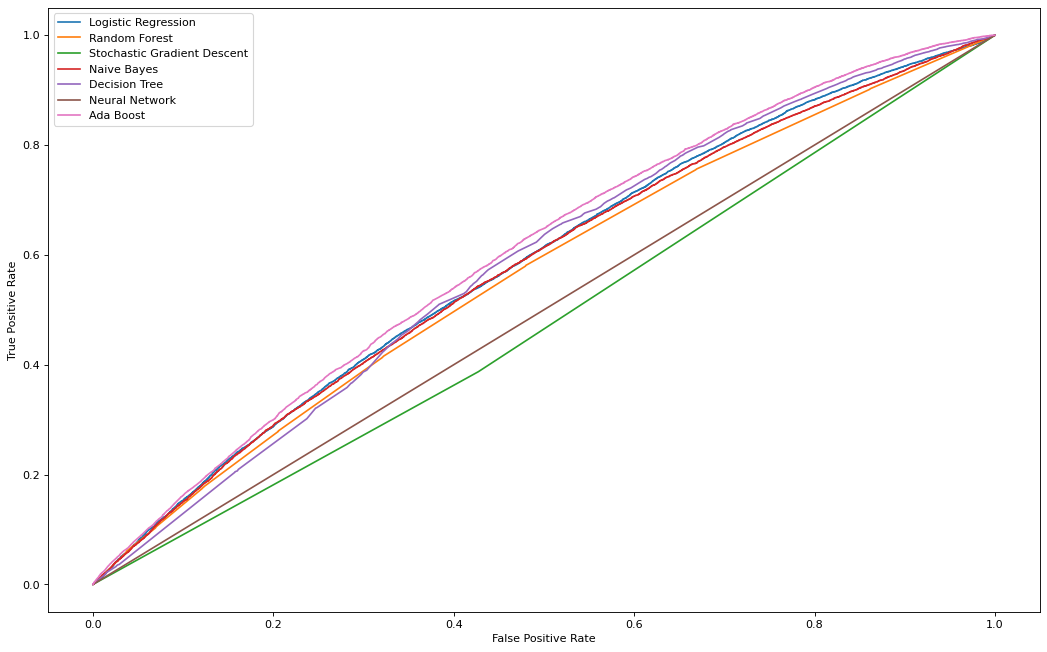

In [483]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1S,tpr1S,label='Logistic Regression')
plt.plot(fpr2S,tpr2S,label='Random Forest')
plt.plot(fpr3S,tpr3S,label='Stochastic Gradient Descent')
plt.plot(fpr4S,tpr4S,label='Naive Bayes')
plt.plot(fpr5S,tpr5S,label='Decision Tree')
plt.plot(fpr6S,tpr6S,label='Neural Network')
plt.plot(fpr7S,tpr7S,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

**Upsampling**

In [484]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

(225493, 44)

In [485]:
from sklearn.utils import resample

X = pd.concat([X_train, y_train], axis=1)

not_fraud = X[X.LOAN_DEFAULT==0]
fraud = X[X.LOAN_DEFAULT==1]

In [486]:
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

upsampled = pd.concat([not_fraud, fraud_upsampled])

upsampled.LOAN_DEFAULT.value_counts()

y_up = upsampled.LOAN_DEFAULT
X_up = upsampled.drop('LOAN_DEFAULT', axis=1)

Decision Tree

In [487]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtreeUP = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_up, y_up)

# predict on test set
dtree_predUP = dtreeUP.predict(X_test)
print(confusion_matrix(y_test, dtree_predUP))
print(round(accuracy_score(y_test, dtree_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, dtree_predUP))
print("F1 Score ",f1_score(y_test, dtree_predUP))
print("Recall Score ",recall_score(y_test, dtree_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_predUP))

[[23339 20785]
 [ 4536  7714]]
55.00000000000001
Accuracy of model  0.5508390392734239
F1 Score  0.3786105180495226
Recall Score  0.6297142857142857
Balanced Accuracy Score  0.5793277257598715


Stochastic Gradient Classifier

In [488]:
from sklearn.linear_model import SGDClassifier

# train model
sgdUP = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_up, y_up)

# predict on test set
sgd_predUP = sgdUP.predict(X_test)
print(confusion_matrix(y_test, sgd_predUP))
print(round(accuracy_score(y_test, sgd_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, sgd_predUP))
print("F1 Score ",f1_score(y_test, sgd_predUP))
print("Recall Score ",recall_score(y_test, sgd_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_predUP))

[[16683 27441]
 [ 4084  8166]]
44.0
Accuracy of model  0.4407883066661936
F1 Score  0.3412666903483294
Recall Score  0.6666122448979592
Balanced Accuracy Score  0.5223528997130535


Logistic Regression

In [489]:
from sklearn.linear_model import LogisticRegression

# train model
logmodelUP = LogisticRegression().fit(X_up,y_up)
logpredUP = logmodelUP.predict(X_test)

print(confusion_matrix(y_test, logpredUP))
print(round(accuracy_score(y_test, logpredUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, logpredUP))
print("F1 Score ",f1_score(y_test, logpredUP))
print("Recall Score ",recall_score(y_test, logpredUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, logpredUP))

[[20901 23223]
 [ 4393  7857]]
51.0
Accuracy of model  0.5101287827722
F1 Score  0.36265866605123476
Recall Score  0.6413877551020408
Balanced Accuracy Score  0.5575377720302154


Random Forest Classifier

In [490]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfcUP = RandomForestClassifier(n_estimators=10).fit(X_up, y_up)

# predict on test set
rfc_predUP = rfcUP.predict(X_test)
print(confusion_matrix(y_test, rfc_predUP))
print(round(accuracy_score(y_test, rfc_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_predUP))
print("F1 Score ",f1_score(y_test, rfc_predUP))
print("Recall Score ",recall_score(y_test, rfc_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_predUP))

[[39104  5020]
 [10168  2082]]
73.0
Accuracy of model  0.7305850214637953
F1 Score  0.21517155849524597
Recall Score  0.16995918367346938
Balanced Accuracy Score  0.528094449963831


Naive Bayes

In [491]:
from sklearn.naive_bayes import GaussianNB

nbUP = GaussianNB().fit(X_up, y_up)
nb_predUP = nbUP.predict(X_test)

print(confusion_matrix(y_test, nb_predUP))
print(round(accuracy_score(y_test, nb_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, nb_predUP))
print("F1 Score ",f1_score(y_test, nb_predUP))
print("Recall Score ",recall_score(y_test, nb_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, nb_predUP))

[[ 3944 40180]
 [  678 11572]]
28.000000000000004
Accuracy of model  0.2752332635612162
F1 Score  0.3616136995718884
Recall Score  0.9446530612244898
Balanced Accuracy Score  0.5170187615976497


Neural Network

In [492]:
from sklearn.neural_network import MLPClassifier

mlpUP = MLPClassifier( activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlpUP.fit(X_up,y_up)
mlp_predUP = mlpUP.predict(X_test)

print(confusion_matrix(y_test, mlp_predUP))
print(round(accuracy_score(y_test, mlp_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, mlp_predUP))
print("F1 Score ",f1_score(y_test, mlp_predUP))
print("Recall Score ",recall_score(y_test, mlp_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, mlp_predUP))

[[44122     2]
 [12250     0]]
78.0
Accuracy of model  0.7826657679071912
F1 Score  0.0
Recall Score  0.0
Balanced Accuracy Score  0.4999773365968634


Ada Boost

In [493]:
from sklearn.ensemble import AdaBoostClassifier

adaUP = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
adaUP.fit(X_up, y_up)
ada_predUP = adaUP.predict(X_test)

print(confusion_matrix(y_test, ada_predUP))
print(round(accuracy_score(y_test, ada_predUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, ada_predUP))
print("F1 Score ",f1_score(y_test, ada_predUP))
print("Recall Score ",recall_score(y_test, ada_predUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, ada_predUP))

[[24017 20107]
 [ 4281  7969]]
56.99999999999999
Accuracy of model  0.5673892219817647
F1 Score  0.3952288845905867
Recall Score  0.6505306122448979
Balanced Accuracy Score  0.5974187826884901


In [494]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodelUP.predict_proba(X_test)[::,1]
fpr1U, tpr1U, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfcUP.predict_proba(X_test)[::,1]
fpr2U, tpr2U, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Stochastic Gradient Descent
y_pred_proba3 = sgdUP.predict_proba(X_test)[::,1]
fpr3U, tpr3U, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nbUP.predict_proba(X_test)[::,1]
fpr4U, tpr4U, _ = metrics.roc_curve(y_test,y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtreeUP.predict_proba(X_test)[::,1]
fpr5U, tpr5U, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlpUP.predict_proba(X_test)[::,1]
fpr6U, tpr6U, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = adaUP.predict_proba(X_test)[::,1]
fpr7U, tpr7U, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

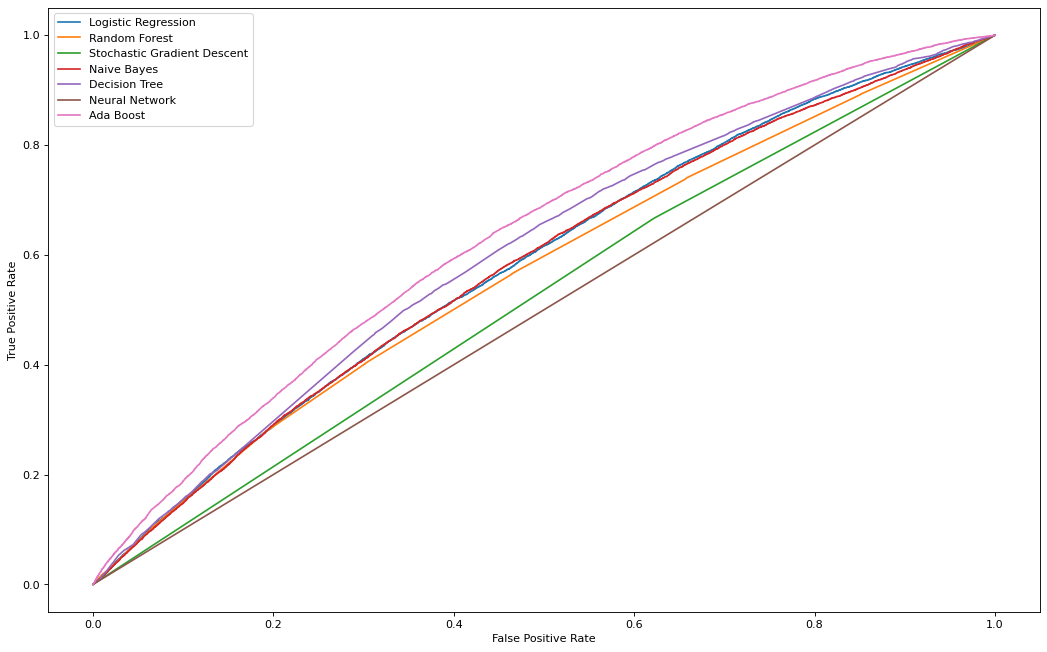

In [495]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1U,tpr1U,label='Logistic Regression')
plt.plot(fpr2U,tpr2U,label='Random Forest')
plt.plot(fpr3U,tpr3U,label='Stochastic Gradient Descent')
plt.plot(fpr4U,tpr4U,label='Naive Bayes')
plt.plot(fpr5U,tpr5U,label='Decision Tree')
plt.plot(fpr6U,tpr6U,label='Neural Network')
plt.plot(fpr7U,tpr7U,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

**DownSampling**

In [496]:
y = train_dummy[['LOAN_DEFAULT']]
X= train_dummy.loc[:, train_dummy.columns != 'LOAN_DEFAULT']
X.shape

(225493, 44)

In [497]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.LOAN_DEFAULT==0]
fraud = X[X.LOAN_DEFAULT==1]

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.LOAN_DEFAULT.value_counts()

y_down = downsampled.LOAN_DEFAULT
X_down = downsampled.drop('LOAN_DEFAULT', axis=1)

Decision Tree

In [498]:
from sklearn.tree import DecisionTreeClassifier

# train model
dtreeDOWN = DecisionTreeClassifier(max_depth = 10, random_state= 101, max_features =None , min_samples_leaf = 30).fit(X_down, y_down)

# predict on test set
dtree_predDOWN = dtreeDOWN.predict(X_test)
print(confusion_matrix(y_test, dtree_predDOWN))
print(round(accuracy_score(y_test, dtree_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, dtree_predDOWN))
print("F1 Score ",f1_score(y_test, dtree_predDOWN))
print("Recall Score ",recall_score(y_test, dtree_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, dtree_predDOWN))

[[24280 19844]
 [ 4788  7462]]
56.00000000000001
Accuracy of model  0.5630609855607195
F1 Score  0.377287895641622
Recall Score  0.6091428571428571
Balanced Accuracy Score  0.5797051426499346


Stochastic Gradient Descent

In [499]:
from sklearn.linear_model import SGDClassifier

# train model
sgdDOWN = SGDClassifier(loss= "modified_huber", shuffle = True, random_state= 101).fit(X_down, y_down)

# predict on test set
sgd_predDOWN = sgdDOWN.predict(X_test)
print(confusion_matrix(y_test, sgd_predDOWN))
print(round(accuracy_score(y_test, sgd_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, sgd_predDOWN))
print("F1 Score ",f1_score(y_test, sgd_predDOWN))
print("Recall Score ",recall_score(y_test, sgd_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, sgd_predDOWN))

[[22346 21778]
 [ 5228  7022]]
52.0
Accuracy of model  0.5209493738248129
F1 Score  0.3421193666260658
Recall Score  0.5732244897959183
Balanced Accuracy Score  0.5398304481433585


Logistic Regression

In [500]:
from sklearn.linear_model import LogisticRegression

# train model
logmodelDOWN = LogisticRegression().fit(X_down,y_down)
logpredDOWN = logmodelDOWN.predict(X_test)

print(confusion_matrix(y_test, logpredDOWN))
print(round(accuracy_score(y_test, logpredDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, logpredDOWN))
print("F1 Score ",f1_score(y_test, logpredDOWN))
print("Recall Score ",recall_score(y_test, logpredDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, logpredDOWN))

[[20924 23200]
 [ 4392  7858]]
51.0
Accuracy of model  0.5105545109447618
F1 Score  0.3628890736122656
Recall Score  0.6414693877551021
Balanced Accuracy Score  0.5578392174928171


Random Forest

In [501]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfcDOWN = RandomForestClassifier(n_estimators=10).fit(X_down, y_down)

# predict on test set
rfc_predDOWN = rfcDOWN.predict(X_test)
print(confusion_matrix(y_test, rfc_predDOWN))
print(round(accuracy_score(y_test, rfc_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, rfc_predDOWN))
print("F1 Score ",f1_score(y_test, rfc_predDOWN))
print("Recall Score ",recall_score(y_test, rfc_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, rfc_predDOWN))

[[27739 16385]
 [ 6331  5919]]
60.0
Accuracy of model  0.5970482846702381
F1 Score  0.34259420038201077
Recall Score  0.48318367346938773
Balanced Accuracy Score  0.5559219065379755


Naive Bayes

In [502]:
from sklearn.naive_bayes import GaussianNB

nbDOWN = GaussianNB().fit(X_down, y_down)
nb_predDOWN = nbDOWN.predict(X_test)

print(confusion_matrix(y_test, nb_predDOWN))
print(round(accuracy_score(y_test, nb_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, nb_predDOWN))
print("F1 Score ",f1_score(y_test, nb_predDOWN))
print("Recall Score ",recall_score(y_test, nb_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, nb_predDOWN))

[[ 5503 38621]
 [  995 11255]]
30.0
Accuracy of model  0.29726469649129034
F1 Score  0.36232817177993115
Recall Score  0.9187755102040817
Balanced Accuracy Score  0.521746108832437


Neural Network

In [503]:
from sklearn.neural_network import MLPClassifier

mlpDOWN = MLPClassifier( activation='relu', solver='sgd', max_iter=500,learning_rate='adaptive')
mlpDOWN.fit(X_down,y_down)
mlp_predDOWN = mlpDOWN.predict(X_test)

print(confusion_matrix(y_test, mlp_predDOWN))
print(round(accuracy_score(y_test, mlp_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, mlp_predDOWN))
print("F1 Score ",f1_score(y_test, mlp_predDOWN))
print("Recall Score ",recall_score(y_test, mlp_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, mlp_predDOWN))

[[    0 44124]
 [    0 12250]]
22.0
Accuracy of model  0.21729875474509525
F1 Score  0.3570179529027745
Recall Score  1.0
Balanced Accuracy Score  0.5


Ada Boost

In [504]:
from sklearn.ensemble import AdaBoostClassifier

adaDOWN = AdaBoostClassifier(n_estimators=1000,
                         learning_rate=0.5)
adaDOWN.fit(X_down, y_down)
ada_predDOWN = adaDOWN.predict(X_test)

print(confusion_matrix(y_test, ada_predDOWN))
print(round(accuracy_score(y_test, ada_predDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, ada_predDOWN))
print("F1 Score ",f1_score(y_test, ada_predDOWN))
print("Recall Score ",recall_score(y_test, ada_predDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, ada_predDOWN))

[[24083 20041]
 [ 4382  7868]]
56.99999999999999
Accuracy of model  0.5667683683967787
F1 Score  0.3918424263552379
Recall Score  0.6422857142857142
Balanced Accuracy Score  0.5940442260124066


In [505]:
from sklearn import metrics

# Logistic Regression
y_pred_proba1 = logmodelDOWN.predict_proba(X_test)[::,1]
fpr1D, tpr1D, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

# Random Forest
y_pred_proba2 = rfcDOWN.predict_proba(X_test)[::,1]
fpr2D, tpr2D, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

# Stochastic Gradient Descent
y_pred_proba3 = sgdDOWN.predict_proba(X_test)[::,1]
fpr3D, tpr3D, _ = metrics.roc_curve(y_test,  y_pred_proba3)
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)

# Naive Bayes
y_pred_proba4 = nbDOWN.predict_proba(X_test)[::,1]
fpr4D, tpr4D, _ = metrics.roc_curve(y_test,y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

# Decision Tree
y_pred_proba5 = dtreeDOWN.predict_proba(X_test)[::,1]
fpr5D, tpr5D, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

# Neural Network
y_pred_proba6 = mlpDOWN.predict_proba(X_test)[::,1]
fpr6D, tpr6D, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

# Ada Boost
y_pred_proba7 = adaDOWN.predict_proba(X_test)[::,1]
fpr7D, tpr7D, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

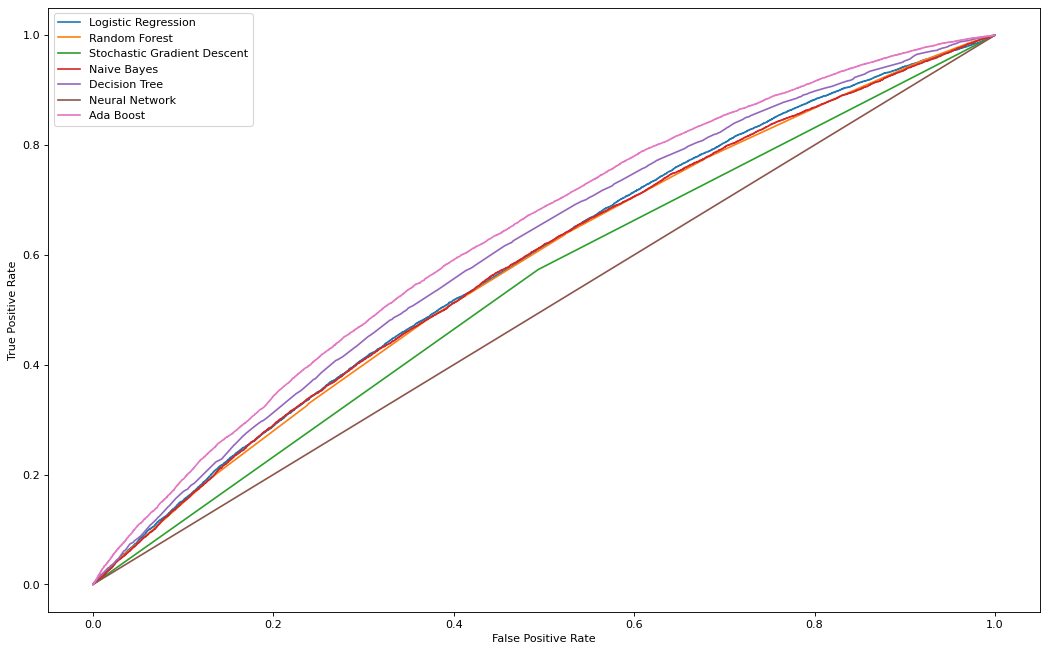

In [506]:
from matplotlib.pyplot import figure

figure(figsize=(16, 10), dpi=80)
plt.plot(fpr1D,tpr1D,label='Logistic Regression')
plt.plot(fpr2D,tpr2D,label='Random Forest')
plt.plot(fpr3D,tpr3D,label='Stochastic Gradient Descent')
plt.plot(fpr4D,tpr4D,label='Naive Bayes')
plt.plot(fpr5D,tpr5D,label='Decision Tree')
plt.plot(fpr6D,tpr6D,label='Neural Network')
plt.plot(fpr7D,tpr7D,label='Ada Boost')
# plt.plot([0,1],[0,1],label='Diagonal')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [507]:
y_testDOWN=[]
for i in range(0,len(nb_predDOWN)):
    a=nb_predDOWN[i]+ada_predDOWN[i]+mlp_predDOWN[i]+rfc_predDOWN[i]+logpredDOWN[i]+sgd_predDOWN[i]+dtree_predDOWN[i]
    if a>=4:
        y_testDOWN.append(1)
    else:
        y_testDOWN.append(0)
y_testDOWN
print(confusion_matrix(y_test, y_testDOWN))
print(round(accuracy_score(y_test, y_testDOWN),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, y_testDOWN))
print("F1 Score ",f1_score(y_test, y_testDOWN))
print("Recall Score ",recall_score(y_test, y_testDOWN))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, y_testDOWN))

[[17599 26525]
 [ 3037  9213]]
48.0
Accuracy of model  0.4756093234469791
F1 Score  0.3839709927481871
Recall Score  0.7520816326530613
Balanced Accuracy Score  0.5754674322271742


In [508]:
y_testUP=[]
for i in range(0,len(nb_predUP)):
    a=nb_predUP[i]+ada_predUP[i]+mlp_predUP[i]+rfc_predUP[i]+logpredUP[i]+sgd_predUP[i]+dtree_predUP[i]
    if a>=4:
        y_testUP.append(1)
    else:
        y_testUP.append(0)
y_testUP
print(confusion_matrix(y_test, y_testUP))
print(round(accuracy_score(y_test, y_testUP),2)*100)
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
print("Accuracy of model ",accuracy_score(y_test, y_testUP))
print("F1 Score ",f1_score(y_test, y_testUP))
print("Recall Score ",recall_score(y_test, y_testUP))
print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, y_testUP))

[[25863 18261]
 [ 5183  7067]]
57.99999999999999
Accuracy of model  0.5841345301025296
F1 Score  0.3761243280642929
Recall Score  0.5768979591836735
Balanced Accuracy Score  0.5815207772529736


In [509]:
for j in range(0,8):
    y_testSMOTE=[]
    for i in range(0,len(nb_predSMOTE)):
        a=nb_predSMOTE[i]+ada_predSMOTE[i]+mlp_predSMOTE[i]+rfc_predSMOTE[i]+logpredSMOTE[i]+sgd_predSMOTE[i]+dtree_predSMOTE[i]
        if a>=j:
            y_testSMOTE.append(1)
        else:
            y_testSMOTE.append(0)
    y_testSMOTE
    print(confusion_matrix(y_test, y_testSMOTE))
    print(round(accuracy_score(y_test, y_testSMOTE),2)*100)
    from sklearn.metrics import f1_score
    from sklearn.metrics import balanced_accuracy_score
    print("Accuracy of model ",accuracy_score(y_test, y_testSMOTE))
    print("F1 Score ",f1_score(y_test, y_testSMOTE))
    print("Recall Score ",recall_score(y_test, y_testSMOTE))
    print("Balanced Accuracy Score ",balanced_accuracy_score(y_test, y_testSMOTE))

[[    0 44124]
 [    0 12250]]
22.0
Accuracy of model  0.21729875474509525
F1 Score  0.3570179529027745
Recall Score  1.0
Balanced Accuracy Score  0.5
[[    0 44124]
 [    0 12250]]
22.0
Accuracy of model  0.21729875474509525
F1 Score  0.3570179529027745
Recall Score  1.0
Balanced Accuracy Score  0.5
[[   48 44076]
 [    5 12245]]
22.0
Accuracy of model  0.21806151772093518
F1 Score  0.3571480655087428
Recall Score  0.9995918367346939
Balanced Accuracy Score  0.5003398400426257
[[ 8597 35527]
 [ 1533 10717]]
34.0
Accuracy of model  0.34260474686912407
F1 Score  0.3664307450336787
Recall Score  0.8748571428571429
Balanced Accuracy Score  0.534847209811311
[[30814 13310]
 [ 7208  5042]]
64.0
Accuracy of model  0.636037889807358
F1 Score  0.32952094634337625
Recall Score  0.41159183673469385
Balanced Accuracy Score  0.5549709704931741
[[39366  4758]
 [10132  2118]]
74.0
Accuracy of model  0.7358711462731046
F1 Score  0.2214786154972289
Recall Score  0.17289795918367348
Balanced Accuracy S

In [510]:
def create_df_feature_importance(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def plot_feature_importance(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    plt.figure(figsize=(16,12))
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

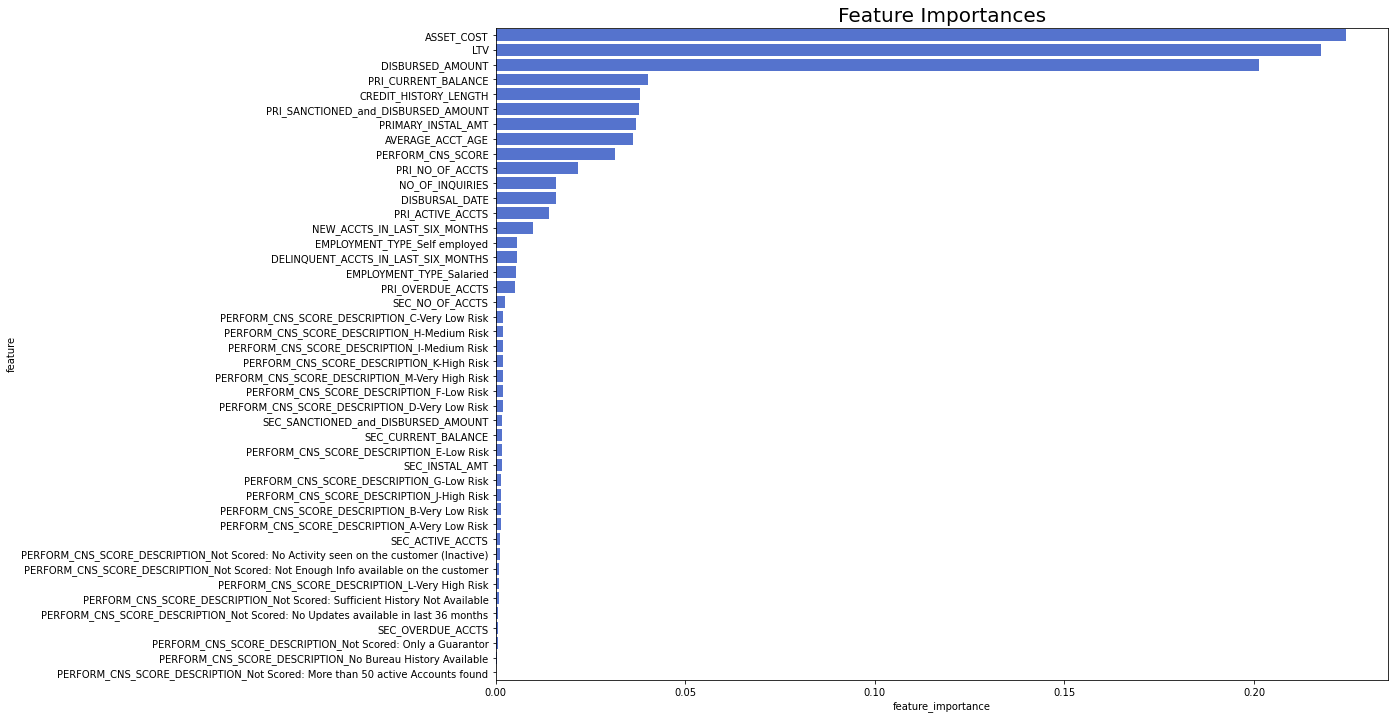

In [511]:
base_imp = create_df_feature_importance(X_train.columns, rfc.feature_importances_)

plot_feature_importance(base_imp, 'Feature Importances')